# Task 1
# The example tutorial given to us feeds in letter by letter into the forward pass. The code below is the same implementation with different hidden size.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch.nn as nn

import torch.optim as optim

import torch.nn.functional as F

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size,hidden_size,batch_size,num_layers,output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
    
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers)
        self.linear = nn.Linear(self.hidden_size, output_size)
        
      
    def initHidden(self):
        return (torch.zeros(self.num_layers,self.batch_size,self.hidden_size),torch.zeros(self.num_layers,self.batch_size,self.hidden_size))
        
    def forward(self,input):
        lstm_out , self.hidden = self.lstm(input.view(len(input),self.batch_size,-1))
#         print(input.view(len(input),self.batch_size,-1).size())
        y_pred = self.linear(lstm_out[-1].view(self.batch_size,-1))
        return F.log_softmax(y_pred)
    
# n_hidden = 128
# batch_size = 1
# num_layers = 1
# lstm = LSTM(n_letters,n_hidden,batch_size,num_layers,n_categories)


In [5]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor,learning_rate,criterion,optimizer,lstm):
    hidden = lstm.initHidden()
    lstm.train(mode = True)
    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        print(line_tensor[i].shape)
        output = lstm(line_tensor[i])
        
    optimizer.zero_grad()
#     print(output.size(),category_tensor.size())
#     print(output.shape,category_tensor.shape)
    loss = criterion(output, category_tensor)
    
    optimizer.step()
    loss.backward()


    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

def validation(category_tensor, line_tensor):
    hidden = lstm.initHidden()

    lstm.zero_grad()
    
    with torch.no_grad():
        for i in range(line_tensor.size()[0]):
            output = lstm(line_tensor[i])

    #     print(output.size(),category_tensor.size())
    #     print(output.shape,category_tensor.shape)
        loss = criterion(output, category_tensor)


    # Add parameters' gradients to their values, multiplied by learning rate
        for p in lstm.parameters():
            p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

# Just return an output given a line
def evaluate(line_tensor,lstm):
    hidden = lstm.initHidden()
    lstm.train(mode = False)

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i])

    return output


In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

#print(categoryFromOutput(output))

In [7]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)
    #print(category_tensor,line_tensor)

category = Russian / line = Vijonsky
category = Spanish / line = Rana
category = Japanese / line = Fukusaku
category = Irish / line = Diarmaid
category = Korean / line = Jeon
category = Vietnamese / line = Huynh
category = English / line = Yoman
category = Russian / line = Awetisoff
category = Scottish / line = Muir
category = Greek / line = Panayiotopoulos


In [8]:
import time
import math


# Keep track of losses for plotting

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def trainAndValidate(n_iters,print_every,plot_every,epoch,n_confusion,lstm,optimizer,criterion,n_hidden,learning_rate):
    start = time.time()
    total_loss_list = []
    for epoch in range(epoch):
        current_loss = 0
        all_losses = []
        total_loss = 0
        for iter in range(1, n_iters + 1):
            category, line, category_tensor, line_tensor = randomTrainingExample()
            output, loss = train(category_tensor, line_tensor,learning_rate,criterion,optimizer,lstm)

            current_loss += loss
            total_loss += loss

            # Print iter number, loss, name and guess
            if iter % print_every == 0:
                guess, guess_i = categoryFromOutput(output)
                correct = '✓' if guess == category else '✗ (%s)' % category
                print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

            # Add current loss avg to list of losses
            if iter % plot_every == 0:
                all_losses.append(current_loss / plot_every)
                current_loss = 0
        total_loss_list.append(total_loss/n_iters)


        confusion = torch.zeros(n_categories, n_categories)

        for i in range(n_confusion):
            category, line, category_tensor, line_tensor = randomTrainingExample()
            output = evaluate(line_tensor,lstm)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

        accuracy = torch.sum(torch.diag(confusion))/n_confusion

        plt.figure()
        plt.title('epoch: ' + str(epoch) + ', n_hidden: ' + str(n_hidden))
        plt.plot(all_losses)
        # Normalize by dividing every row by its sum #per class accuracy

        for i in range(n_categories):
            confusion[i] = confusion[i] / confusion[i].sum()

        diag_confusion = torch.diag(confusion)
        print("accuracy: ",accuracy.item())
    #     print(confusion)
    #     print(diag_confusion)
        print("class wise accuracy:")
        for i in range(diag_confusion.size()[0]):
            print (all_categories[i],diag_confusion[i].item())

        # Set up plot
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(confusion.numpy())
        fig.colorbar(cax)

        # Set up axes
        ax.set_xticklabels([''] + all_categories, rotation=90)
        ax.set_yticklabels([''] + all_categories)

        # Force label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # sphinx_gallery_thumbnail_number = 2
        plt.show()
        
    plt.figure()
    plt.title('loss per epoch')
    plt.plot(total_loss_list)

In [9]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
n_hidden1 = 128
n_hidden2 = 200
n_hidden3 = 300
batch_size = 1
# num_layers = 1

n_iters = 100000
print_every = 5000
plot_every = 1000
epoch = 3
n_confusion = 10000
criterion = nn.NLLLoss()
num_layers_ls = [1,2]
for num_layers in num_layers_ls:
    print("NUMBER OF LAYERS: ", num_layers)
    lstm1 = LSTM(n_letters,n_hidden1,batch_size,num_layers,n_categories)
    lstm2 = LSTM(n_letters,n_hidden2,batch_size,num_layers,n_categories)
    lstm3 = LSTM(n_letters,n_hidden3,batch_size,num_layers,n_categories)
    optimizer1 = optim.SGD(lstm1.parameters(), lr=0.1)
    optimizer2 = optim.SGD(lstm2.parameters(), lr=0.1)
    optimizer3 = optim.SGD(lstm3.parameters(), lr=0.1)
    trainAndValidate(n_iters,print_every,plot_every,epoch,n_confusion,lstm1,optimizer1,criterion,n_hidden1,learning_rate)
    trainAndValidate(n_iters,print_every,plot_every,epoch,n_confusion,lstm2,optimizer2,criterion,n_hidden2,learning_rate)
    trainAndValidate(n_iters,print_every,plot_every,epoch,n_confusion,lstm3,optimizer3,criterion,n_hidden3,learning_rate)






NUMBER OF LAYERS:  1
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])


torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])


torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])


torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])


torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])


torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])


KeyboardInterrupt: 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 27s) 2.8612 Horiatis / Portuguese ✗ (Greek)
10000 10% (0m 53s) 2.8803 Ribeiro / French ✗ (Portuguese)
15000 15% (1m 21s) 2.9415 Watson / Italian ✗ (Scottish)
20000 20% (1m 47s) 2.8648 Jedynak / German ✗ (Polish)
25000 25% (2m 13s) 2.8589 Horiatis / Russian ✗ (Greek)
30000 30% (2m 38s) 2.8834 Pae / English ✗ (Korean)
35000 35% (3m 3s) 2.9394 Simpson / Irish ✗ (Scottish)
40000 40% (3m 28s) 2.9445 Auttenberg / Greek ✗ (Polish)
45000 45% (3m 53s) 2.9448 Cavey / Polish ✗ (French)
50000 50% (4m 18s) 2.8639 Martin / Portuguese ✗ (Scottish)
55000 55% (4m 45s) 2.9382 Villiger / Portuguese ✗ (English)
60000 60% (5m 13s) 2.9992 Klerk / Portuguese ✗ (Dutch)
65000 65% (5m 44s) 2.8047 Morishita / Japanese ✓
70000 70% (6m 10s) 2.7431 Henriques / Portuguese ✓
75000 75% (6m 36s) 2.7677 Blanco / Spanish ✓
80000 80% (7m 2s) 2.8828 Kann / Portuguese ✗ (Dutch)
85000 85% (7m 30s) 2.9301 Wronski / Italian ✗ (Polish)
90000 90% (7m 56s) 2.9340 Villalobos / Greek ✗ (Spanish)
95000 95% (8m 22s) 2.486

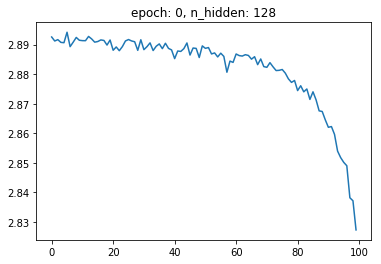

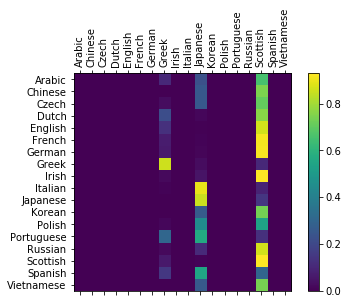

5000 5% (9m 49s) 2.9029 Dubnikov / Scottish ✗ (Russian)
10000 10% (10m 16s) 2.8337 Bell / French ✗ (Scottish)
15000 15% (10m 44s) 2.7497 Nam / Korean ✓
20000 20% (11m 18s) 2.8553 Knepp / Vietnamese ✗ (German)
25000 25% (11m 56s) 2.7059 Jenicek / Polish ✗ (Czech)
30000 30% (12m 33s) 2.7434 Srour / Dutch ✗ (Arabic)
35000 35% (13m 10s) 1.5773 Obuchi / Italian ✗ (Japanese)
40000 40% (13m 47s) 1.9887 Sadowski / Italian ✗ (Polish)
45000 45% (14m 23s) 2.2256 Rahmanin / Irish ✗ (Russian)
50000 50% (14m 59s) 1.9495 Paredes / Greek ✗ (Portuguese)
55000 55% (15m 36s) 0.9291 Paloumbas / Greek ✓
60000 60% (16m 12s) 3.0226 Cerney / Scottish ✗ (Czech)
65000 65% (16m 49s) 4.6923 Aonghus / Greek ✗ (Irish)
70000 70% (17m 26s) 1.9458 Hout / French ✗ (Dutch)
75000 75% (18m 6s) 1.8095 Thibault / French ✓
80000 80% (18m 49s) 2.8179 Hanania / Spanish ✗ (Arabic)
85000 85% (19m 31s) 1.7400 Melendez / Spanish ✓
90000 90% (20m 9s) 6.2730 Colon / Irish ✗ (Spanish)
95000 95% (20m 47s) 1.8535 Chavez / Portuguese ✗ 

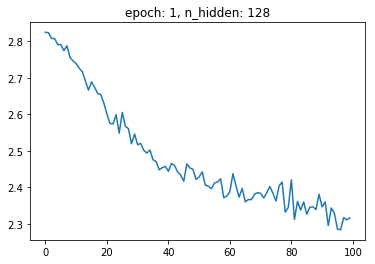

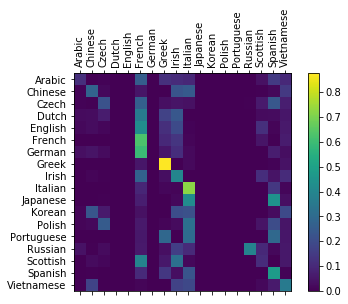

5000 5% (22m 51s) 0.9642 Dritsas / Greek ✓
10000 10% (23m 26s) 2.6899 Sabbagh / Russian ✗ (Arabic)
15000 15% (24m 2s) 2.5281 Luttrell / German ✗ (English)
20000 20% (24m 37s) 1.6886 Shu / Korean ✗ (Chinese)
25000 25% (25m 13s) 1.4736 Rozinek / Polish ✗ (Czech)
30000 30% (25m 47s) 2.6259 Samson / Irish ✗ (French)
35000 35% (26m 21s) 1.8542 Bissette / French ✓
40000 40% (26m 55s) 2.5544 Boyle / French ✗ (Scottish)
45000 45% (27m 29s) 1.6372 Lichkanovsky / Russian ✓
50000 50% (28m 5s) 1.3133 Deng / Chinese ✓
55000 55% (28m 40s) 2.0365 Boucher / German ✗ (French)
60000 60% (29m 16s) 2.3979 Chun / Irish ✗ (Korean)
65000 65% (29m 52s) 3.0358 Shamon / Irish ✗ (Arabic)
70000 70% (30m 27s) 2.4282 Mas / Greek ✗ (Dutch)
75000 75% (31m 3s) 3.7627 Cha / Japanese ✗ (Korean)
80000 80% (31m 40s) 1.1093 Xiong / Chinese ✓
85000 85% (32m 16s) 3.3207 Huffman / Chinese ✗ (German)
90000 90% (32m 52s) 2.6481 An / Scottish ✗ (Vietnamese)
95000 95% (33m 27s) 3.0800 Kozlow / Korean ✗ (Polish)
100000 100% (34m 3

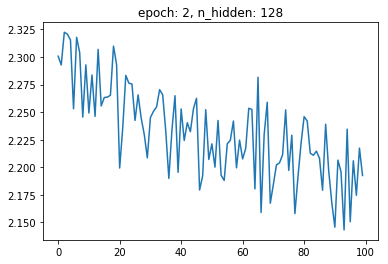

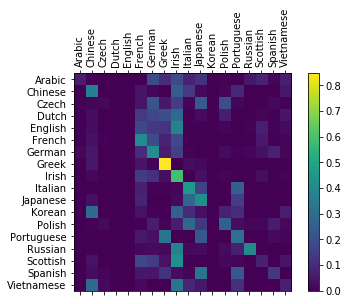

5000 5% (0m 41s) 2.8806 Marie / Greek ✗ (French)
10000 10% (1m 24s) 2.9629 Maly / Spanish ✗ (Polish)
15000 15% (2m 6s) 2.8857 Cabello / Scottish ✗ (Spanish)
20000 20% (2m 47s) 2.8628 Muggia / French ✗ (Italian)
25000 25% (3m 30s) 2.8614 Salvay / Greek ✗ (Italian)
30000 30% (4m 13s) 2.8334 Mach / Portuguese ✗ (Vietnamese)
35000 35% (4m 55s) 2.8964 Ubina / Vietnamese ✗ (Spanish)
40000 40% (5m 37s) 2.9424 Lynes / Scottish ✗ (English)
45000 45% (6m 20s) 2.8891 Kringos / Dutch ✗ (Greek)
50000 50% (7m 2s) 2.8531 Youj / Scottish ✗ (Korean)
55000 55% (7m 45s) 2.8228 Robertson / Korean ✗ (Scottish)
60000 60% (8m 27s) 2.8921 Sook / Russian ✗ (Korean)
65000 65% (9m 7s) 2.8713 Kowalczyk / Czech ✗ (Polish)
70000 70% (9m 50s) 2.8797 Lehmann / Irish ✗ (German)
75000 75% (10m 32s) 2.7800 Hernandez / Spanish ✓
80000 80% (11m 15s) 2.8794 Sneijders / Portuguese ✗ (Dutch)
85000 85% (11m 57s) 2.9307 Corraidhin / Chinese ✗ (Irish)
90000 90% (12m 40s) 2.9046 Charushkin / Irish ✗ (Russian)
95000 95% (13m 23s)

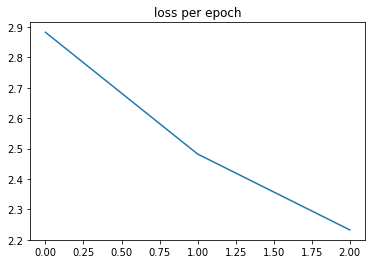

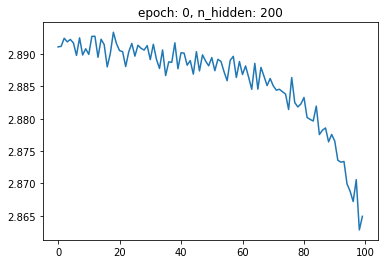

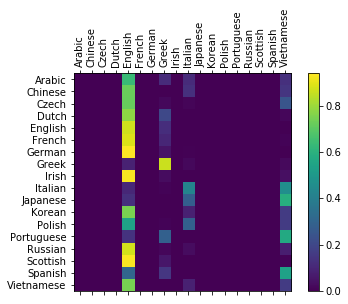

5000 5% (15m 41s) 2.9632 Schubert / Korean ✗ (Czech)
10000 10% (16m 22s) 2.9183 Yakir / Scottish ✗ (Russian)
15000 15% (17m 3s) 2.6185 Sinagra / Italian ✓
20000 20% (17m 43s) 2.4950 Nunes / Greek ✗ (Portuguese)
25000 25% (18m 24s) 2.2799 Esteves / Greek ✗ (Portuguese)
30000 30% (19m 5s) 2.9402 Langbroek / Russian ✗ (Dutch)
35000 35% (19m 46s) 2.6249 Hiu / Chinese ✓
40000 40% (20m 27s) 2.7377 Assaf / Korean ✗ (Arabic)
45000 45% (21m 8s) 2.7011 an / Irish ✗ (Vietnamese)
50000 50% (21m 49s) 2.4722 Husk / Chinese ✗ (Czech)
55000 55% (22m 30s) 2.6373 Gim / Russian ✗ (Chinese)
60000 60% (23m 11s) 1.7667 Hayashida / Portuguese ✗ (Japanese)
65000 65% (23m 52s) 2.3480 Bosko / Japanese ✗ (Polish)
70000 70% (24m 33s) 2.8053 Jian / Irish ✗ (Chinese)
75000 75% (25m 14s) 1.7133 Chang / Chinese ✗ (Korean)
80000 80% (25m 55s) 1.7915 Tong / Chinese ✗ (Vietnamese)
85000 85% (26m 34s) 2.0177 Cardozo / Japanese ✗ (Portuguese)
90000 90% (27m 18s) 2.2192 Gui / Italian ✗ (Chinese)
95000 95% (28m 3s) 1.8233 O

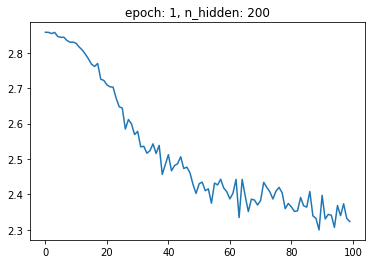

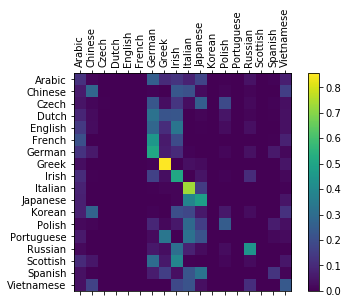

5000 5% (30m 22s) 1.8629 Gu / Chinese ✗ (Korean)
10000 10% (31m 7s) 1.5773 Iwasa / Japanese ✓
15000 15% (31m 51s) 4.6536 Genovese / French ✗ (Italian)
20000 20% (32m 35s) 1.8223 Zdunowski / Italian ✗ (Polish)
25000 25% (33m 19s) 3.0106 Harman / Irish ✗ (German)
30000 30% (34m 3s) 0.8132 Geracimos / Greek ✓
35000 35% (34m 47s) 2.1499 Aodh / Russian ✗ (Irish)
40000 40% (35m 31s) 2.2057 Gomolka / Japanese ✗ (Polish)
45000 45% (36m 15s) 1.8652 Anderson / Irish ✗ (Scottish)
50000 50% (36m 59s) 2.2185 Warn / Irish ✗ (English)
55000 55% (37m 39s) 2.4901 O'Neal / German ✗ (Irish)
60000 60% (38m 24s) 2.5688 Simon / Irish ✗ (French)
65000 65% (39m 5s) 1.5669 Esposito / Italian ✓
70000 70% (39m 48s) 1.3672 Guerriero / Italian ✓
75000 75% (40m 32s) 2.8356 Leroy / Russian ✗ (French)
80000 80% (41m 16s) 2.6556 Schulz / Spanish ✗ (German)
85000 85% (42m 1s) 1.9017 Bustillo / Italian ✗ (Spanish)
90000 90% (42m 45s) 3.8968 Nave / French ✗ (Italian)
95000 95% (43m 29s) 3.0798 Nazari / Italian ✗ (Arabic)

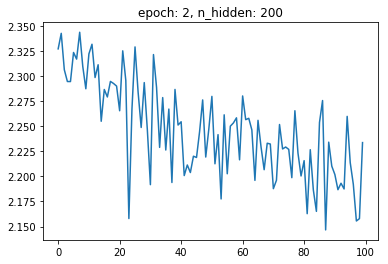

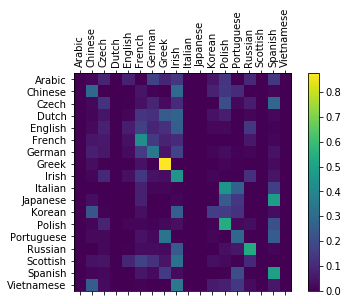

5000 5% (1m 7s) 2.9273 Velazquez / Dutch ✗ (Spanish)
10000 10% (2m 15s) 2.9206 Jerihin / Irish ✗ (Russian)
15000 15% (3m 20s) 3.0248 Royer / Italian ✗ (French)
20000 20% (4m 24s) 2.8205 Labriola / Italian ✓
25000 25% (5m 31s) 2.9426 Templeman / Greek ✗ (English)
30000 30% (6m 39s) 2.7955 Pham / Vietnamese ✓
35000 35% (7m 46s) 2.8425 Forakis / Irish ✗ (Greek)
40000 40% (8m 54s) 2.8634 Rang / Spanish ✗ (Chinese)
45000 45% (10m 1s) 2.8850 Ramsay / German ✗ (Scottish)
50000 50% (11m 9s) 2.9457 Cavallo / Japanese ✗ (Italian)
55000 55% (12m 16s) 2.8244 Calvert / Greek ✗ (English)
60000 60% (13m 24s) 2.8883 Schenk / Arabic ✗ (Czech)
65000 65% (14m 31s) 2.8071 Kui / French ✗ (Chinese)
70000 70% (15m 36s) 2.7926 Taguchi / Japanese ✓
75000 75% (16m 37s) 2.9692 Yim / Greek ✗ (Chinese)
80000 80% (17m 39s) 2.8782 Garrastazu / Greek ✗ (Spanish)
85000 85% (18m 41s) 2.9356 Gwang  / Polish ✗ (Korean)
90000 90% (19m 43s) 2.8790 Vargas / Greek ✗ (Portuguese)
95000 95% (20m 45s) 2.8716 Czajkowski / Italia

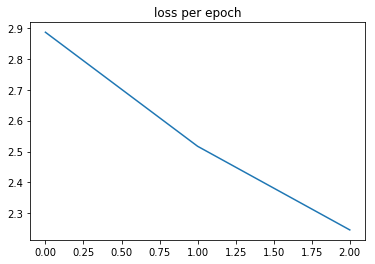

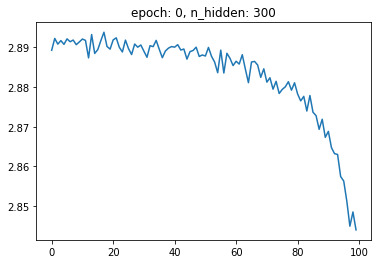

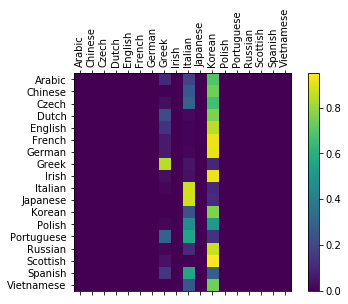

5000 5% (23m 46s) 2.8599 Kuai / Italian ✗ (Chinese)
10000 10% (24m 46s) 2.7765 Carey / Scottish ✗ (Irish)
15000 15% (25m 47s) 2.9759 Meadhra / Italian ✗ (Irish)
20000 20% (26m 48s) 2.8372 Madeira / Italian ✗ (Portuguese)
25000 25% (27m 48s) 2.1346 Nonomura / Italian ✗ (Japanese)
30000 30% (28m 49s) 2.7474 Sarraf / Vietnamese ✗ (Arabic)
35000 35% (29m 46s) 1.9729 Saigo / Japanese ✓
40000 40% (30m 47s) 1.7953 Okawa / Japanese ✓
45000 45% (31m 48s) 4.4336 Collins / Greek ✗ (Irish)
50000 50% (32m 48s) 2.4283 Trinh / Chinese ✗ (Vietnamese)
55000 55% (33m 49s) 2.4219 Cuidightheach / Russian ✗ (Irish)
60000 60% (34m 50s) 2.7771 Lynch / Russian ✗ (English)
65000 65% (35m 50s) 2.1160 Melo / Japanese ✗ (Portuguese)
70000 70% (36m 51s) 2.3117 Bradach / Russian ✗ (Irish)
75000 75% (37m 52s) 2.2710 Guerra / Portuguese ✗ (Italian)
80000 80% (38m 53s) 1.3041 Ambrosi / Italian ✓
85000 85% (39m 54s) 2.4003 Dam / Vietnamese ✓
90000 90% (40m 55s) 2.1034 Sneijder / French ✗ (Dutch)
95000 95% (41m 56s) 2.0

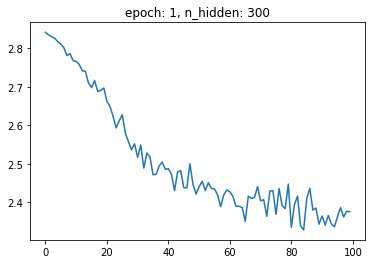

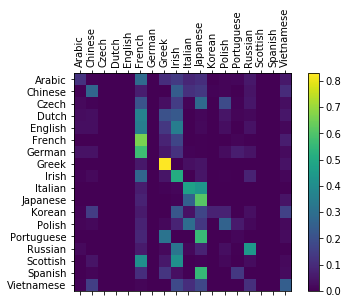

5000 5% (44m 52s) 1.5145 Zhevakhov / Russian ✓
10000 10% (45m 55s) 1.2681 Atamoglanov / Russian ✓
15000 15% (46m 57s) 2.1321 Macdonald / French ✗ (Scottish)
20000 20% (47m 58s) 2.3438 Thai / Italian ✗ (Vietnamese)
25000 25% (49m 1s) 2.5662 Miller / German ✗ (Scottish)
30000 30% (50m 3s) 1.9831 Boucher / German ✗ (French)
35000 35% (51m 5s) 1.2400 Ying / Chinese ✓
40000 40% (52m 7s) 3.8859 King / Chinese ✗ (Scottish)
45000 45% (53m 9s) 2.4354 Vertman / Irish ✗ (Russian)
50000 50% (54m 11s) 2.1849 Rocha / Japanese ✗ (Portuguese)
55000 55% (55m 13s) 2.1937 Szweda / Japanese ✗ (Polish)
60000 60% (56m 13s) 2.4896 San / Scottish ✗ (Korean)
65000 65% (57m 16s) 2.5194 Shadid / Scottish ✗ (Arabic)
70000 70% (58m 21s) 2.6566 Kools / Greek ✗ (Dutch)
75000 75% (59m 27s) 1.6873 Rosa / Japanese ✗ (Spanish)
80000 80% (60m 32s) 1.6780 Perrault / French ✓
85000 85% (61m 37s) 2.1385 Jolley / Russian ✗ (English)
90000 90% (62m 43s) 2.0733 Nassar / German ✗ (Arabic)
95000 95% (63m 50s) 2.5136 Wheeler / Ge

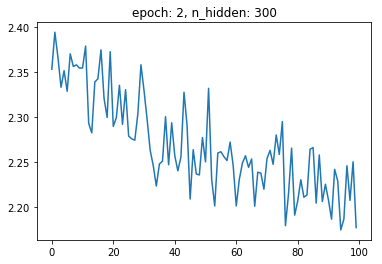

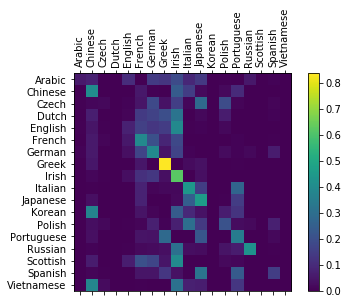

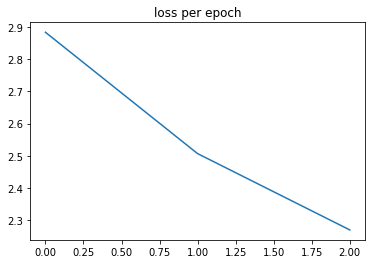

In [10]:
epoch = 3
num_layers = 2
lstm1 = LSTM(n_letters,n_hidden1,batch_size,num_layers,n_categories)
lstm2 = LSTM(n_letters,n_hidden2,batch_size,num_layers,n_categories)
lstm3 = LSTM(n_letters,n_hidden3,batch_size,num_layers,n_categories)

optimizer1 = optim.SGD(lstm1.parameters(), lr=0.1)
optimizer2 = optim.SGD(lstm2.parameters(), lr=0.1)
optimizer3 = optim.SGD(lstm3.parameters(), lr=0.1)

criterion = nn.NLLLoss()

trainAndValidate(n_iters,print_every,plot_every,epoch,n_confusion,lstm1,optimizer1,criterion,n_hidden1,learning_rate)
trainAndValidate(n_iters,print_every,plot_every,epoch,n_confusion,lstm2,optimizer2,criterion,n_hidden2,learning_rate)
trainAndValidate(n_iters,print_every,plot_every,epoch,n_confusion,lstm3,optimizer3,criterion,n_hidden3,learning_rate)

plt.figure()
plt.plot(total_lost_list)

In [ ]:
print(lineToTensor('Jones').size())
print(lineToTensor('SAMSON').size())

# Task 2:
# For task 2, we are required to run the code with different batchsizes. From the tutotial code, the forward pass processes letter by letter. It is possible to process 2 letters or more at a time, HOWEVER, given the ambiguity in the question and the circumstances such as the need for a new nn.Module function whereby the forward pass processes a word instead of a letter. This makes sense as in Task 2b, we are required to use batch sizes of 1, 10 and 30. If the batch size is 30 and we process 30 letters at once, it no longer makes sense as not all words are that long.
# I will still be using the random training example to be as close to the tutorial as possible, however, I will be changing the nn.Module class.
## Note: using a random training example generation as given by the tutorial is not good for training as it might be biased to certain groups and is not a good representation of the population. ALSO, there is a possibility that the validation and test examples are the same. However, I will still be using the random training example generation to try to not deviate too much from the example tutorial
## test accuracy and error is evaluated with batch size of 1.

In [19]:
import time
import math
import numpy as np

def categoryFromOutputBatch(output,batch_size):
#     print(output)
    category_ls = []
    for i in range(batch_size):
        top_n, top_i = output[i].topk(1)
#         print(top_n,top_i)
        category_i = top_i[0].item()
#         print(category_i)
        category_ls.append((all_categories[category_i],category_i))
    return category_ls

#print(categoryFromOutput(output))

def evaluateBatch(line_tensor,lstm,line_len):
    hidden = lstm.initHidden()
    lstm.train(mode = False)
    output = lstm(line_tensor,hidden,line_len)
#     output = lstm(line_tensor)

    return output

#print(categoryFromOutput(output))
class LSTMnew(nn.Module):
    def __init__(self, input_size,hidden_size,batch_size,num_layers,output_size):
        super(LSTMnew, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
    
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers)
        self.linear = nn.Linear(self.hidden_size, output_size)
        
      
    def initHidden(self):
        return (torch.zeros(self.num_layers,self.batch_size,self.hidden_size),torch.zeros(self.num_layers,self.batch_size,self.hidden_size))
        
    def forward(self,x,hidden,X_lengths):
        X = torch.nn.utils.rnn.pack_padded_sequence(x, X_lengths)

        # now run through LSTM
        X , self.hidden = self.lstm(X,hidden)#.view(len(X),self.batch_size,-1),hidden)

        # undo the packing operation
        X, _ = torch.nn.utils.rnn.pad_packed_sequence(X)#, batch_first=True)
#         print(input.view(len(input),self.batch_size,-1).size())


        X = X.contiguous()
#         X = X.view(-1, X.shape[2])

#         # run through actual linear layer
#         X = self.hidden_to_tag(X)

#         # ---------------------
#         # 4. Create softmax activations bc we're doing classification
#         # Dim transformation: (batch_size * seq_len, nb_lstm_units) -> (batch_size, seq_len, nb_tags)
#         X = F.log_softmax(X, dim=1)

#         # I like to reshape for mental sanity so we're back to (batch_size, seq_len, nb_tags)
#         X = X.view(batch_size, seq_len, self.nb_tags)
        y_pred = self.linear(X[-1].view(self.batch_size,-1))
        return F.log_softmax(y_pred)



def trainBatch(category_tensor, line_tensor,learning_rate,criterion,optimizer,lstm,line_len):
    hidden = lstm.initHidden()
    lstm.train(mode = True)
    lstm.zero_grad()
#     print(line_tensor.size())

#     for i in range(line_tensor.size()[0]):
#         output = lstm(line_tensor[i])
        
    output = lstm(line_tensor,hidden,line_len) # puts in word by word
#     print(output)
#     print(output.size())
#     print(category_tensor.size())
    optimizer.zero_grad()
#     print(output.size(),category_tensor.size())
#     print(output.shape,category_tensor.shape)
    loss = criterion(output, category_tensor.long())
    
    optimizer.step()
    loss.backward()


    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def makeBatch(batch_size):
    category_tensor_ls = []
    line_tensor_ls = []
    category_ls = []
    line_ls = []
    sorted_category_ls = []
    sorted_line_ls = []
    for i in range(batch_size):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        category_tensor_ls.append(category_tensor)
        line_tensor_ls.append(line_tensor)
        line_ls.append(line)
        category_ls.append(category)
#         print(line)
#         print(line_tensor.size())
#         print(category_tensor)
    
    
    line_lengths = [len(sentence) for sentence in line_tensor_ls]
#     print(line_lengths)
    longest_sent = max(line_lengths)
    padded_batch = torch.zeros([longest_sent,batch_size,n_letters])
#     print(padded_batch.size())
    padded_category_tensor = torch.zeros([batch_size])
#     line_lengths.sort(reverse=True)
    sorted_index = sorted(range(len(line_lengths)), key=lambda k: -line_lengths[k])
#     print(sorted_index)
    for i,idx in enumerate(sorted_index):
        sorted_line_ls.append(line_ls[idx])
        sorted_category_ls.append(category_ls[idx])
        line_len = line_lengths[idx] -1
#         print(padded_batch[0:line_len,i,:].size())
#         print(line_tensor_ls[i].size())
#         print(line_tensor_ls[i][line_len,:,:])
        padded_batch[0:line_len,i,:] = line_tensor_ls[idx][line_len,:,:]
        padded_category_tensor[i]=category_tensor_ls[idx]
        
    line_lengths.sort(reverse=True)
    return sorted_line_ls, sorted_category_ls, line_lengths, padded_category_tensor, padded_batch

# a = makeBatch(5)
# print(a[0])
# print(pb.size())
# print(pct)

def trainAndValidateBatch(n_iters,print_every,plot_every,epoch,n_confusion,lstm,optimizer,criterion,n_hidden,learning_rate,batch_size):
    start = time.time()
    total_loss_list = []
    accuracy_ls_test = []
    error_ls_train = []
    error_ls_test = []
    accuracy_ls_train = []
    for epoch in range(epoch):
        current_loss = 0
        all_losses = []
        total_loss = 0
        
        confusion_train = torch.zeros(n_categories, n_categories)
        
        for iter in range(1, n_iters + 1):
#             print('here')
            line_ls, category_ls, line_len, category_tensor, line_tensor = makeBatch(batch_size)#randomTrainingExample()
#             print('cat',category_tensor)
#             print(line, category_tensor,line_tensor)
#             print(category)
            output, loss = trainBatch(category_tensor, line_tensor,learning_rate,criterion,optimizer,lstm,line_len)
            
        
#             category_ls = categoryFromOutputBatch(output,batch_size)
#             for j in range(batch_size):
#                 category_i = all_categories.index(category_ls[j])
#                 confusion_train[category_i][category_ls[i][1]] += 1
# #             print(output.size())
            guess_ls = categoryFromOutputBatch(output,batch_size)
            for j in range(batch_size):
                category_i = all_categories.index(category_ls[j])
                confusion_train[category_i][guess_ls[j][1]] += 1



            current_loss += loss
            total_loss += loss
            # Print iter number, loss, name and guess
            if iter % print_every == 0:
            
#                 guess_ls = categoryFromOutputBatch(output,batch_size)
#                 print(guess_ls)
                for i, guess in enumerate(guess_ls):
#                     print(guess)
                    correct = '✓' if guess[0] == category_ls[i] else '✗ (%s)' % category_ls[i]
#                 print('%d %d%% (%s) loss = %.4f ' % (iter, iter / n_iters * 100, timeSince(start), loss))
                print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line_ls[i], guess[0], correct))
# if iter % print_every == 0:
#                 guess, guess_i = categoryFromOutput(output)
#                 correct = '✓' if guess == category else '✗ (%s)' % category
                

            # Add current loss avg to list of losses
            if iter % plot_every == 0:
                all_losses.append(current_loss / plot_every)
                current_loss = 0
        
        print(torch.sum(torch.diag(confusion_train)))
        ## calculating loss and accuracy
#         print(confusion_train)
#         print(torch.sum(confusion_train))
#         print(n_iters)
        accuracy = torch.sum(torch.diag(confusion_train))/n_iters/batch_size

        plt.figure()
        plt.title('epoch: ' + str(epoch) + ', n_hidden: ' + str(n_hidden))
        plt.plot(all_losses)
        # Normalize by dividing every row by its sum #per class accuracy

        for f in range(n_categories):
            confusion_train[f] = confusion_train[f] / confusion_train[f].sum()

        diag_confusion = torch.diag(confusion_train)
        print("train accuracy: ",accuracy.item())
        print("train error: ", 1- accuracy.item())
        accuracy_ls_train.append(accuracy.item())
        error_ls_train.append(1-accuracy.item())
    #     print(confusion)
#         print(diag_confusion.size())
#         print(diag_confusion)
        print("train class wise accuracy:")
        for j in range(diag_confusion.size()[0]):
            print (all_categories[j],diag_confusion[j].item())

        # Set up plot
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(confusion_train.numpy())
        fig.colorbar(cax)

        # Set up axes
        ax.set_xticklabels([''] + all_categories, rotation=90)
        ax.set_yticklabels([''] + all_categories)

        # Force label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # sphinx_gallery_thumbnail_number = 2
        plt.show()
                
        total_loss_list.append(total_loss/n_iters)
        
        
        confusion = torch.zeros(n_categories, n_categories)

        for i in range(n_confusion):
#             print(batch_size)
#             print(line_len)
            line_ls, category_ls, line_len, category_tensor, line_tensor = makeBatch(batch_size)#randomTrainingExample()
#           
            output = evaluateBatch(line_tensor,lstm,line_len)
            guess_ls = categoryFromOutputBatch(output,batch_size)
#             print(guess_ls)
#             print(category_ls)
            for j in range(batch_size):
                category_i = all_categories.index(category_ls[j])
                confusion[category_i][guess_ls[j][1]] += 1

        accuracy = torch.sum(torch.diag(confusion))/n_confusion/batch_size

        plt.figure()
        plt.title('epoch: ' + str(epoch) + ', n_hidden: ' + str(n_hidden))
        plt.plot(all_losses)
        # Normalize by dividing every row by its sum #per class accuracy

        for i in range(n_categories):
            confusion[i] = confusion[i] / confusion[i].sum()

        #### THERE IS A PROBLEM HERE ####
        diag_confusion = torch.diag(confusion)
        
        
        accuracy_ls_test.append(accuracy.item())
        error_ls_test.append(1-accuracy.item())
        print("test accuracy: ",accuracy.item())
        print("test error: ", 1- accuracy.item())
    #     print(confusion)
    #     print(diag_confusion)
        print("test class wise accuracy:")
        for i in range(diag_confusion.size()[0]):
            print (all_categories[i],diag_confusion[i].item())

        # Set up plot
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(confusion.numpy())
        fig.colorbar(cax)

        # Set up axes
        ax.set_xticklabels([''] + all_categories, rotation=90)
        ax.set_yticklabels([''] + all_categories)

        # Force label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        # sphinx_gallery_thumbnail_number = 2
        plt.show()

        
    plt.figure()
    plt.title("loss per epoch")
    plt.plot(total_loss_list)
    plt.figure()
    plt.title("train accuracy per epoch")
    plt.plot(accuracy_ls_train)
    plt.figure()
    plt.title("train error per epoch")
    plt.plot(error_ls_train)
    plt.figure()
    plt.title("test accuracy per epoch")
    plt.plot(accuracy_ls_test)
    plt.figure()
    plt.title("test error per epoch")
    plt.plot(error_ls_test)
    

#     accuracy_ls_test = []
#     error_ls_train = []
#     error_ls_test = []

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


5000 5% (0m 53s) 2.8653 Mulryan / Portuguese ✗ (Irish)
10000 10% (1m 37s) 2.8055 D'ambrosio / Russian ✗ (Italian)
15000 15% (2m 1s) 2.8023 Apeldoorn / Scottish ✗ (Dutch)
20000 20% (2m 25s) 2.8408 Berg / Korean ✗ (German)
25000 25% (2m 49s) 1.6145 Yanitsky / Russian ✓
30000 30% (3m 15s) 1.9880 Freund / Scottish ✗ (German)
35000 35% (3m 39s) 2.4563 Choe / Vietnamese ✗ (Korean)
40000 40% (4m 3s) 1.3396 Nam / Chinese ✗ (Korean)
45000 45% (4m 27s) 2.1771 Dubois / Portuguese ✗ (French)
50000 50% (4m 50s) 1.4537 Elizondo / Italian ✗ (Spanish)
55000 55% (5m 14s) 1.4693 Sai / Chinese ✗ (Vietnamese)
60000 60% (5m 37s) 0.5810 Tsai  / Korean ✓
65000 65% (6m 0s) 1.2433 Montagne / French ✓
70000 70% (6m 24s) 1.4359 De santigo / Russian ✗ (Portuguese)
75000 75% (6m 47s) 1.3556 Youj / Vietnamese ✗ (Korean)
80000 80% (7m 11s) 2.5876 Alber / German ✗ (English)
85000 85% (7m 34s) 0.9239 Wong / Chinese ✓
90000 90% (8m 0s) 2.3832 Idane / French ✗ (Japanese)
95000 95% (8m 38s) 1.6541 Cnaimhin / Irish ✓
1000

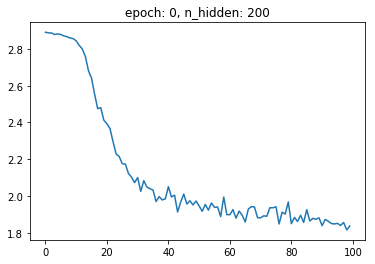

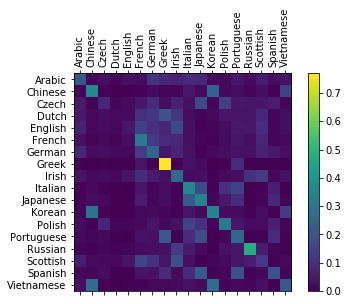

test accuracy:  0.3357999920845032
test error:  0.6642000079154968
test class wise accuracy:
Arabic 0.43272727727890015
Chinese 0.7135231494903564
Czech 0.06909091025590897
Dutch 0.011342154815793037
English 0.10931899398565292
French 0.39508506655693054
German 0.18568995594978333
Greek 0.7482014298439026
Irish 0.5063291192054749
Italian 0.5390334725379944
Japanese 0.41578948497772217
Korean 0.2063492089509964
Polish 0.5333333611488342
Portuguese 0.15084746479988098
Russian 0.4792792797088623
Scottish 0.013651876710355282
Spanish 0.15944881737232208
Vietnamese 0.38376384973526


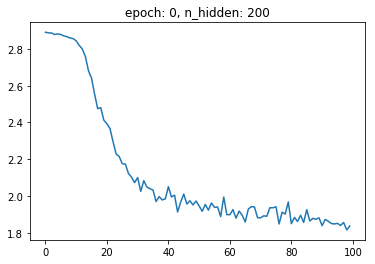

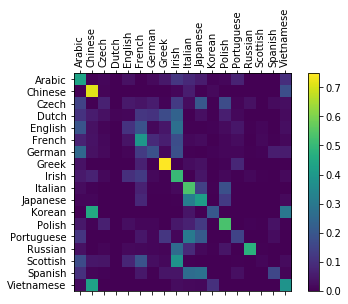

5000 5% (9m 47s) 1.2715 Favreau / French ✓
10000 10% (10m 11s) 3.0055 Shimakage / French ✗ (Japanese)
15000 15% (10m 35s) 0.0110 Kabachev / Russian ✓
20000 20% (10m 58s) 1.3535 Rorris / Portuguese ✗ (Greek)
25000 25% (11m 22s) 0.9398 Wan / Chinese ✓
30000 30% (11m 48s) 2.2086 Mata / Arabic ✗ (Portuguese)
35000 35% (12m 11s) 2.4890 Fernandes / Greek ✗ (Portuguese)
40000 40% (12m 34s) 0.1148 Papadopulos / Greek ✓
45000 45% (12m 59s) 1.7387 Rutten / Dutch ✓
50000 50% (13m 24s) 0.3345 Eliopoulos / Greek ✓
55000 55% (13m 49s) 1.7180 O'Grady / English ✗ (Irish)
60000 60% (14m 13s) 1.2914 Xian / Chinese ✓
65000 65% (14m 36s) 2.9567 Psik / Korean ✗ (Czech)
70000 70% (14m 59s) 1.3714 Cameron / Scottish ✓
75000 75% (15m 23s) 0.0079 Heruvimov / Russian ✓
80000 80% (15m 48s) 2.1103 Maria / Japanese ✗ (Portuguese)
85000 85% (16m 13s) 1.4737 Kawasaki / Italian ✗ (Japanese)
90000 90% (16m 38s) 0.8238 Coelho / Portuguese ✓
95000 95% (17m 3s) 0.4913 Starek / Polish ✓
100000 100% (17m 28s) 2.0188 Muir /

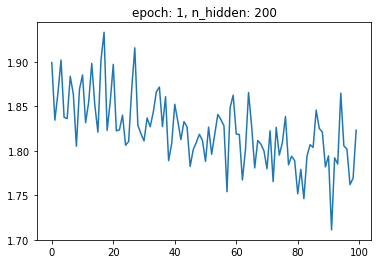

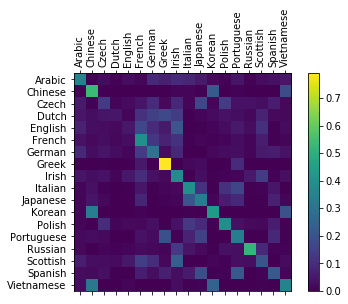

test accuracy:  0.3621000051498413
test error:  0.6378999948501587
test class wise accuracy:
Arabic 0.38756856322288513
Chinese 0.5526801943778992
Czech 0.014362657442688942
Dutch 0.04903677850961685
English 0.00917431153357029
French 0.4944649338722229
German 0.27239489555358887
Greek 0.8175046443939209
Irish 0.5335628390312195
Italian 0.47750866413116455
Japanese 0.3636363744735718
Korean 0.4653979241847992
Polish 0.521276593208313
Portuguese 0.28700360655784607
Russian 0.4920071065425873
Scottish 0.20180180668830872
Spanish 0.2522045969963074
Vietnamese 0.3307839334011078


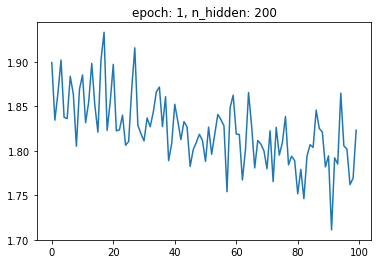

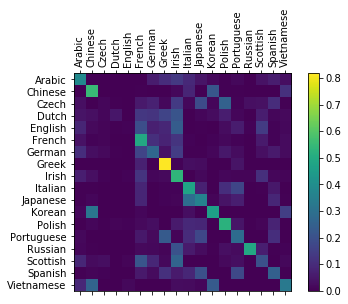

5000 5% (18m 7s) 5.1981 Munro / Portuguese ✗ (Scottish)
10000 10% (18m 32s) 0.4134 Dinh / Vietnamese ✓
15000 15% (18m 57s) 2.8131 Rheem / Arabic ✗ (Korean)
20000 20% (19m 22s) 2.6788 Miller / German ✗ (Scottish)
25000 25% (19m 47s) 3.5128 Thean / Irish ✗ (Chinese)
30000 30% (20m 12s) 1.7635 Yeon / Chinese ✗ (Korean)
35000 35% (20m 37s) 7.3668 Roig / Chinese ✗ (Spanish)
40000 40% (21m 2s) 0.9672 Si / Vietnamese ✗ (Korean)
45000 45% (21m 27s) 1.4656 Wasem / Arabic ✓
50000 50% (21m 51s) 2.3941 Michel / Czech ✗ (French)
55000 55% (22m 16s) 3.1506 Pypin / English ✗ (Russian)
60000 60% (22m 41s) 1.3826 Szewc / Czech ✗ (Polish)
65000 65% (23m 6s) 1.6519 Seighin / Irish ✓
70000 70% (23m 36s) 2.2122 Groer / Arabic ✗ (German)
75000 75% (24m 4s) 3.7081 Beyersdorf / Russian ✗ (German)
80000 80% (24m 32s) 3.9779 Royer / Arabic ✗ (French)
85000 85% (25m 0s) 2.3560 Cardona / Japanese ✗ (Spanish)
90000 90% (25m 28s) 2.5627 Rawlings / Greek ✗ (English)
95000 95% (25m 56s) 0.8508 Kim / Vietnamese ✓
1000

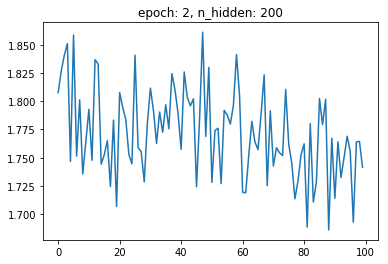

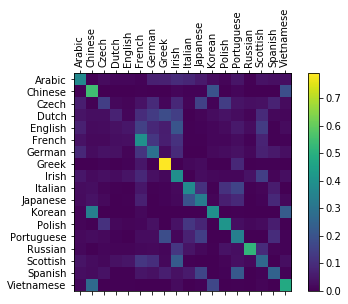

test accuracy:  0.34610000252723694
test error:  0.6538999974727631
test class wise accuracy:
Arabic 0.45255473256111145
Chinese 0.10758377611637115
Czech 0.11929824203252792
Dutch 0.1733800321817398
English 0.0
French 0.43425604701042175
German 0.26062846183776855
Greek 0.7231040596961975
Irish 0.21440823376178741
Italian 0.37827715277671814
Japanese 0.27142858505249023
Korean 0.8393194675445557
Polish 0.39962825179100037
Portuguese 0.5735027194023132
Russian 0.45121949911117554
Scottish 0.2947976887226105
Spanish 0.14022140204906464
Vietnamese 0.4273049533367157


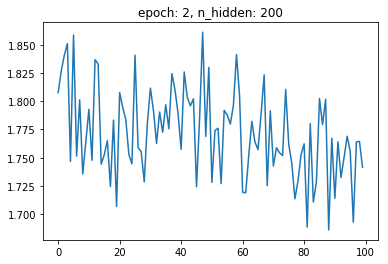

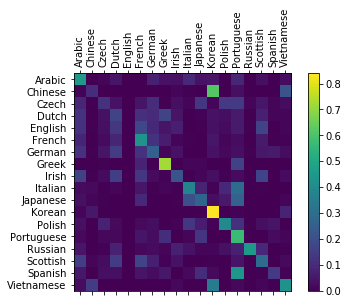

5000 5% (27m 10s) 0.6114 Dziedzic / Polish ✓
10000 10% (27m 38s) 1.1635 Fukuyama / Japanese ✓
15000 15% (28m 7s) 1.5115 Rier / German ✓
20000 20% (28m 36s) 2.4430 Klerken / Russian ✗ (Dutch)
25000 25% (29m 5s) 1.9124 Maessen / Irish ✗ (Dutch)
30000 30% (29m 34s) 4.7626 Guirguis / Greek ✗ (Arabic)
35000 35% (30m 3s) 1.7629 Slivka / Japanese ✗ (Czech)
40000 40% (30m 33s) 1.5161 Shaldybin / Scottish ✗ (Russian)
45000 45% (31m 1s) 0.7534 Johnston / Scottish ✓
50000 50% (31m 27s) 4.3325 Rompuy / Irish ✗ (Dutch)
55000 55% (31m 53s) 0.4168 Ibanez / Spanish ✓
60000 60% (32m 18s) 0.7923 Huynh / Vietnamese ✓
65000 65% (32m 45s) 1.2283 Mcintyre / Scottish ✓
70000 70% (33m 12s) 2.9993 Guerra / Japanese ✗ (Italian)
75000 75% (33m 38s) 1.9123 Mizoguchi / Polish ✗ (Japanese)
80000 80% (34m 3s) 1.4603 Duncan / Irish ✓
85000 85% (34m 28s) 2.0521 Oliver / German ✗ (French)
90000 90% (34m 53s) 0.0017 Tuganbaev / Russian ✓
95000 95% (35m 18s) 1.4947 Marmo / Spanish ✗ (Italian)
100000 100% (35m 43s) 0.3551

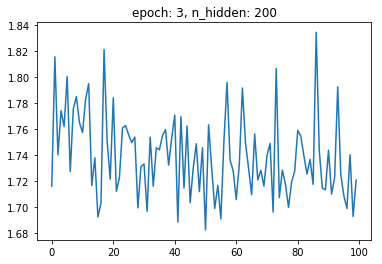

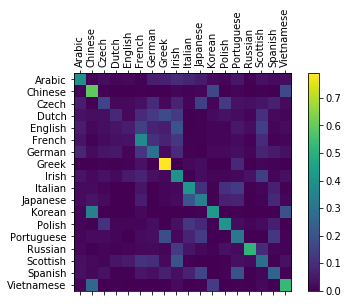

test accuracy:  0.3644999861717224
test error:  0.6355000138282776
test class wise accuracy:
Arabic 0.3626168370246887
Chinese 0.6431159377098083
Czech 0.18233083188533783
Dutch 0.047451671212911606
English 0.19288389384746552
French 0.37634408473968506
German 0.3149905204772949
Greek 0.8478260636329651
Irish 0.34574466943740845
Italian 0.25757575035095215
Japanese 0.2443280965089798
Korean 0.3780260682106018
Polish 0.5062611699104309
Portuguese 0.10752688348293304
Russian 0.5891608595848083
Scottish 0.15136054158210754
Spanish 0.5202952027320862
Vietnamese 0.5108303427696228


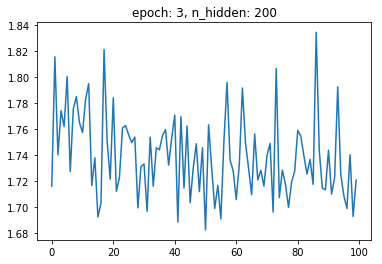

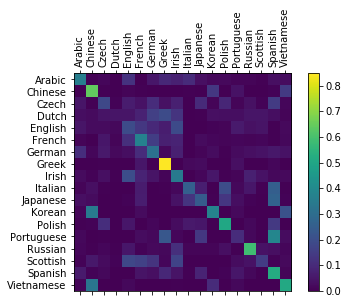

5000 5% (36m 23s) 1.4183 Donnell / Irish ✓
10000 10% (36m 48s) 1.1239 Pinheiro / Portuguese ✓
15000 15% (37m 13s) 1.0803 Rudawski / Italian ✗ (Polish)
20000 20% (37m 41s) 0.3779 Lim  / Korean ✓
25000 25% (38m 9s) 3.2418 Williams / Greek ✗ (English)
30000 30% (38m 38s) 0.5075 Wojewodzki / Polish ✓
35000 35% (39m 7s) 0.7185 Si / Korean ✓
40000 40% (39m 35s) 1.9893 Favager / German ✗ (French)
45000 45% (40m 4s) 1.4659 Shigemitsu / Greek ✗ (Japanese)
50000 50% (40m 32s) 0.6173 Moralez / Spanish ✓
55000 55% (41m 1s) 0.3062 Veselitsky / Russian ✓
60000 60% (41m 29s) 2.0436 Chi / Chinese ✗ (Korean)
65000 65% (41m 57s) 3.9399 Sokolofsky / Russian ✗ (Polish)
70000 70% (42m 26s) 2.4561 Janutka / Japanese ✗ (Czech)
75000 75% (42m 54s) 3.9666 Ba / Vietnamese ✗ (Arabic)
80000 80% (43m 23s) 0.1529 Calogerakis / Greek ✓
85000 85% (43m 51s) 1.5852 Urbanovska / Spanish ✗ (Czech)
90000 90% (44m 19s) 2.0546 Zhao / Portuguese ✗ (Chinese)
95000 95% (44m 48s) 1.5539 Kouri / Italian ✗ (Arabic)
100000 100% (4

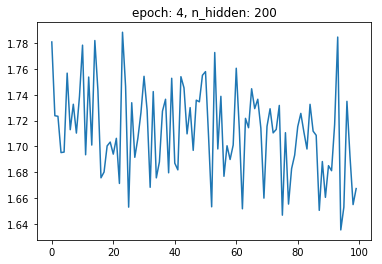

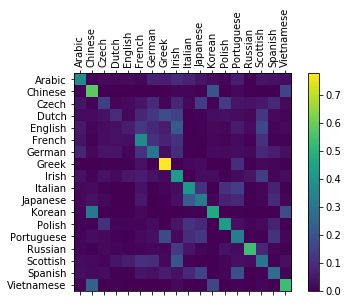

test accuracy:  0.3797000050544739
test error:  0.6202999949455261
test class wise accuracy:
Arabic 0.4118705093860626
Chinese 0.703041136264801
Czech 0.22282609343528748
Dutch 0.06764168292284012
English 0.0964467003941536
French 0.24468085169792175
German 0.4592592716217041
Greek 0.7362068891525269
Irish 0.47643980383872986
Italian 0.6256590485572815
Japanese 0.40566039085388184
Korean 0.47018739581108093
Polish 0.2982456088066101
Portuguese 0.15934066474437714
Russian 0.4805915057659149
Scottish 0.29174312949180603
Spanish 0.19529837369918823
Vietnamese 0.48490944504737854


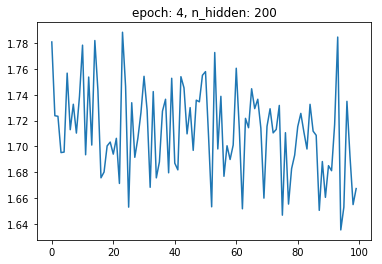

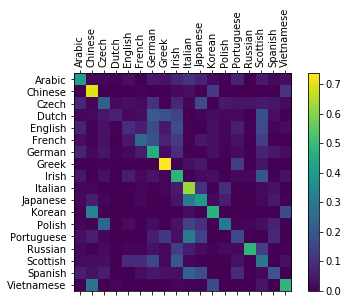

5000 5% (46m 1s) 1.4864 Neyland / English ✓
10000 10% (46m 30s) 0.4757 Makhlinsky / Russian ✓
15000 15% (46m 58s) 1.9068 Mclean / Irish ✗ (Scottish)
20000 20% (47m 26s) 4.2821 Gavril / Czech ✗ (Greek)
25000 25% (47m 51s) 1.5565 Honjas / Portuguese ✗ (Greek)
30000 30% (48m 16s) 1.2579 Onishi / Italian ✗ (Japanese)
35000 35% (48m 41s) 1.8360 Hoult / German ✗ (English)
40000 40% (49m 6s) 0.3860 Piatek / Polish ✓
45000 45% (49m 31s) 2.4288 Braune / Irish ✗ (German)
50000 50% (49m 56s) 0.6886 Youj / Korean ✓
55000 55% (50m 21s) 1.3648 Oyama / Japanese ✓
60000 60% (50m 47s) 0.0091 Bakhtov / Russian ✓
65000 65% (51m 11s) 2.0729 Fujimaki / Italian ✗ (Japanese)
70000 70% (51m 36s) 0.5186 Banh / Vietnamese ✓
75000 75% (52m 1s) 3.8679 Lyon / Korean ✗ (French)
80000 80% (52m 26s) 2.7378 Rosales / Greek ✗ (Spanish)
85000 85% (52m 51s) 0.1297 Ogterop / Dutch ✓
90000 90% (53m 17s) 2.5531 Sabbag / Vietnamese ✗ (Arabic)
95000 95% (53m 45s) 0.4942 Ribeiro / Portuguese ✓
100000 100% (54m 14s) 1.7845 Olle

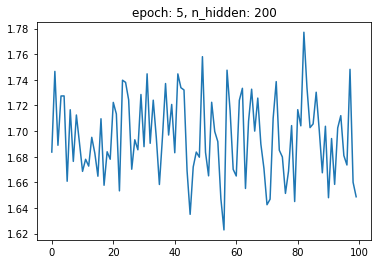

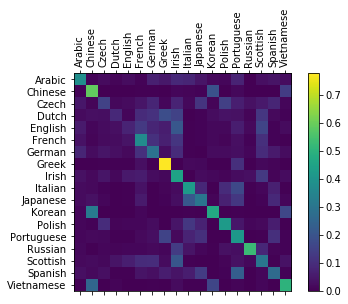

test accuracy:  0.367900013923645
test error:  0.632099986076355
test class wise accuracy:
Arabic 0.3763636350631714
Chinese 0.4651162922382355
Czech 0.11700183153152466
Dutch 0.1484230011701584
English 0.029250457882881165
French 0.37288135290145874
German 0.3426086902618408
Greek 0.8649572730064392
Irish 0.3910806179046631
Italian 0.3732394278049469
Japanese 0.2481481432914734
Korean 0.6641075015068054
Polish 0.47504621744155884
Portuguese 0.020066889002919197
Russian 0.5301645398139954
Scottish 0.1803278625011444
Spanish 0.5646017789840698
Vietnamese 0.45765766501426697


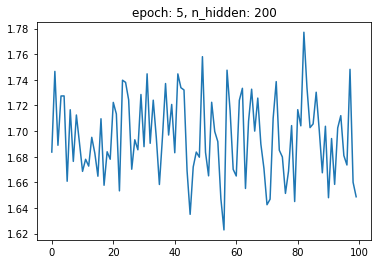

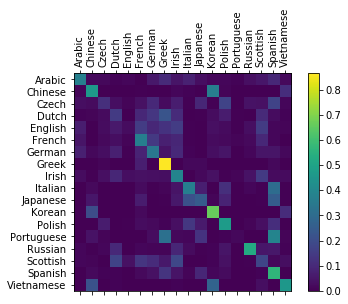

5000 5% (54m 52s) 3.2875 Durante / Irish ✗ (Spanish)
10000 10% (55m 16s) 0.2887 Dinh / Vietnamese ✓
15000 15% (55m 39s) 2.2668 Penner / German ✗ (Dutch)
20000 20% (56m 3s) 4.4832 Tenshin / Irish ✗ (Japanese)
25000 25% (56m 26s) 3.7932 Fergus / Portuguese ✗ (Irish)
30000 30% (56m 50s) 2.7932 Docherty / Irish ✗ (Scottish)
35000 35% (57m 14s) 1.2399 Janicek / Polish ✗ (Czech)
40000 40% (57m 37s) 1.6308 Bachurin / Scottish ✗ (Russian)
45000 45% (58m 1s) 1.6538 Offermans / Greek ✗ (Dutch)
50000 50% (58m 36s) 1.5756 Malone / Irish ✓
55000 55% (59m 25s) 0.8465 Kan / Chinese ✓
60000 60% (60m 11s) 2.0186 Mclaughlin / Russian ✗ (Scottish)
65000 65% (60m 58s) 1.1286 Toma / Arabic ✓
70000 70% (61m 45s) 0.8926 Kim / Vietnamese ✓
75000 75% (62m 34s) 0.9434 Bui / Chinese ✗ (Vietnamese)
80000 80% (63m 22s) 3.0347 Shamoun / Irish ✗ (Arabic)
85000 85% (64m 9s) 3.6357 Lohno / Spanish ✗ (Russian)
90000 90% (64m 56s) 1.7162 Rocha / Spanish ✗ (Portuguese)
95000 95% (65m 44s) 1.5920 Romao / Italian ✗ (Portug

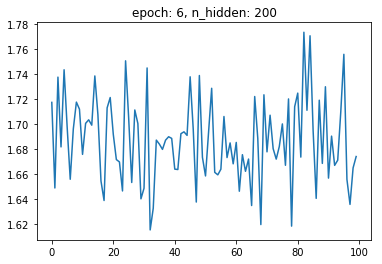

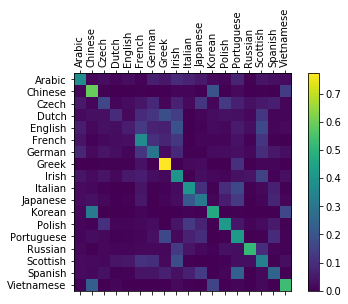

test accuracy:  0.3831000030040741
test error:  0.6168999969959259
test class wise accuracy:
Arabic 0.3315412104129791
Chinese 0.3839869201183319
Czech 0.20106761157512665
Dutch 0.03559870645403862
English 0.1001964658498764
French 0.29230770468711853
German 0.37050360441207886
Greek 0.8309608697891235
Irish 0.45896148681640625
Italian 0.4248608648777008
Japanese 0.30144405364990234
Korean 0.48288288712501526
Polish 0.40839695930480957
Portuguese 0.5157699584960938
Russian 0.49809160828590393
Scottish 0.2698412835597992
Spanish 0.2637362778186798
Vietnamese 0.7383512258529663


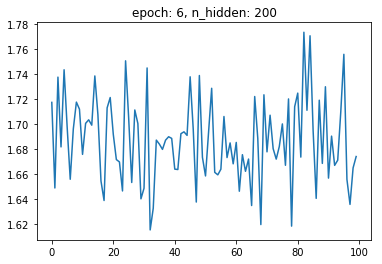

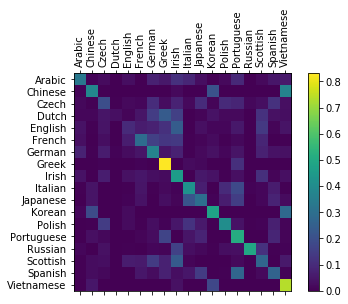

5000 5% (1m 6s) 2.8490 Bui / Chinese ✗ (Vietnamese)
10000 10% (2m 12s) 2.9091 Mulder / Korean ✗ (Dutch)
15000 15% (3m 17s) 2.5088 Ha / Chinese ✗ (Korean)
20000 20% (4m 9s) 2.3249 Lew / Chinese ✓
25000 25% (4m 41s) 2.5411 Coghlan / Chinese ✗ (Irish)
30000 30% (5m 11s) 1.1844 Qiu / Chinese ✓
35000 35% (5m 43s) 3.2580 Ahearn / Korean ✗ (Irish)
40000 40% (6m 15s) 3.6921 Lieu / Korean ✗ (Vietnamese)
45000 45% (6m 46s) 2.6313 Zeng / Korean ✗ (Chinese)
50000 50% (7m 16s) 2.9148 Mojzis / Chinese ✗ (Czech)
55000 55% (7m 48s) 2.8706 Brady / Chinese ✗ (Irish)
60000 60% (8m 22s) 2.0738 Dacey / Vietnamese ✗ (English)
65000 65% (8m 55s) 2.1845 Youn / Vietnamese ✗ (Korean)
70000 70% (9m 28s) 3.0155 Doyle / Vietnamese ✗ (Irish)
75000 75% (9m 59s) 1.3792 Bellomi / Italian ✓
80000 80% (10m 30s) 1.7899 Gordon / Korean ✗ (Scottish)
85000 85% (11m 2s) 1.5071 Knutt / Chinese ✗ (English)
90000 90% (11m 34s) 2.1407 Rang / Chinese ✓
95000 95% (12m 5s) 1.5067 Tze / Vietnamese ✗ (Chinese)
100000 100% (12m 35s) 2

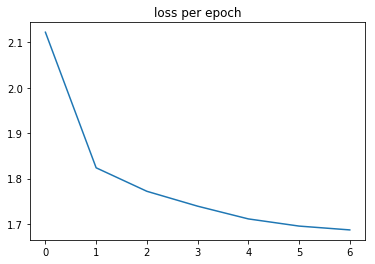

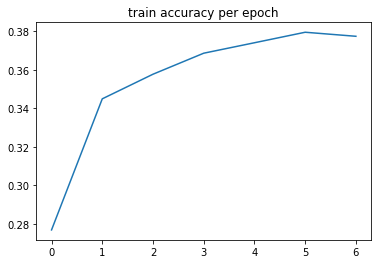

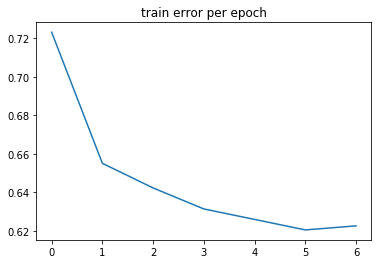

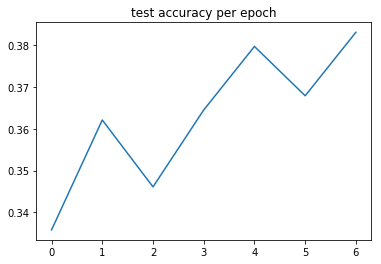

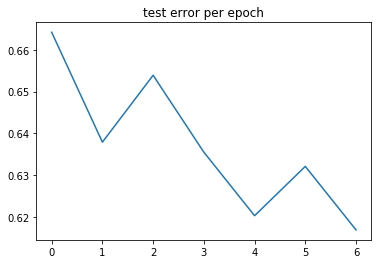

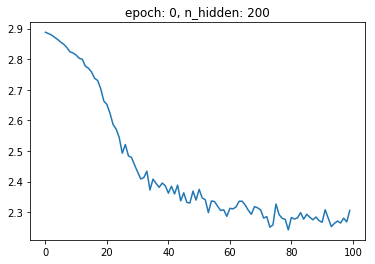

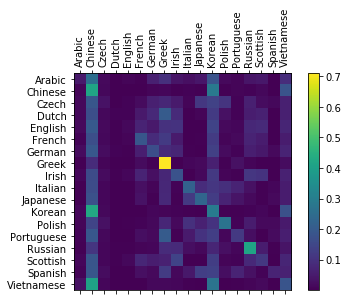

test accuracy:  0.24095000326633453
test error:  0.7590499967336655
test class wise accuracy:
Arabic 0.06504064798355103
Chinese 0.9033989310264587
Czech 0.05263157933950424
Dutch 0.0
English 0.05427782982587814
French 0.2337305247783661
German 0.274795264005661
Greek 0.6688867807388306
Irish 0.21633362770080566
Italian 0.22513088583946228
Japanese 0.23742276430130005
Korean 0.07869142293930054
Polish 0.4244343936443329
Portuguese 0.09973286092281342
Russian 0.5318957567214966
Scottish 0.009057970717549324
Spanish 0.2861085534095764
Vietnamese 0.0


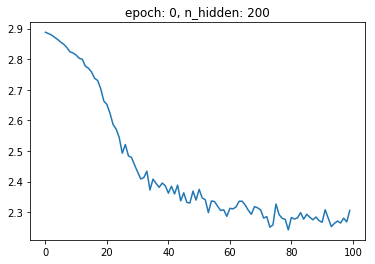

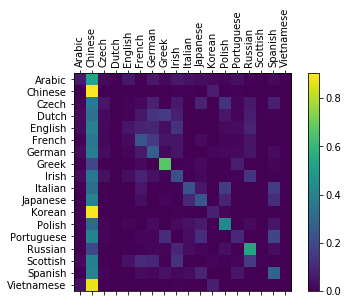

5000 5% (13m 25s) 2.1021 Man / Vietnamese ✗ (Chinese)
10000 10% (13m 59s) 2.4187 Yasuda / Korean ✗ (Japanese)
15000 15% (14m 30s) 2.1640 Chu / Korean ✗ (Vietnamese)
20000 20% (15m 0s) 1.8841 Close / Vietnamese ✗ (Greek)
25000 25% (15m 31s) 1.5583 Cote / Chinese ✗ (French)
30000 30% (16m 2s) 2.7712 Faust / Vietnamese ✗ (English)
35000 35% (16m 38s) 2.0638 Pugh / Korean ✗ (English)
40000 40% (17m 11s) 2.4357 Tsutaya / Vietnamese ✗ (Japanese)
45000 45% (17m 44s) 3.6308 Daly / Arabic ✗ (Irish)
50000 50% (18m 16s) 0.9334 Emanov / Russian ✓
55000 55% (18m 46s) 2.2444 Li / Korean ✓
60000 60% (19m 17s) 1.2321 Chung / Vietnamese ✓
65000 65% (19m 49s) 2.2644 Mclain / Vietnamese ✗ (Irish)
70000 70% (20m 20s) 2.2461 Bao / Korean ✗ (Chinese)
75000 75% (20m 52s) 2.1190 Youn / Korean ✓
80000 80% (21m 25s) 1.5906 Kappel / Vietnamese ✗ (Dutch)
85000 85% (21m 57s) 1.1618 Salvai / Italian ✓
90000 90% (22m 27s) 1.9749 Yu / Korean ✓
95000 95% (22m 58s) 2.6537 Masson / Korean ✗ (French)
100000 100% (23m 28s

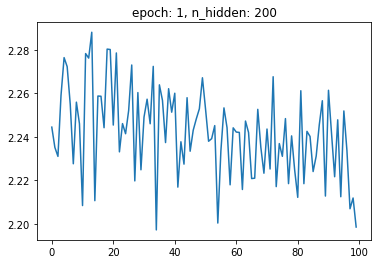

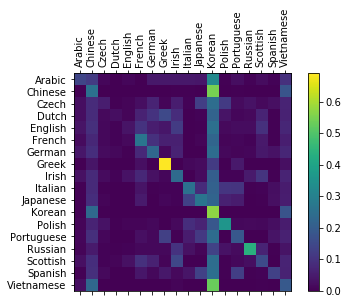

test accuracy:  0.25110000371932983
test error:  0.7488999962806702
test class wise accuracy:
Arabic 0.13821138441562653
Chinese 0.105601467192173
Czech 0.11295972019433975
Dutch 0.035779815167188644
English 0.03743315488100052
French 0.2673179507255554
German 0.2537878751754761
Greek 0.6950998306274414
Irish 0.2322695106267929
Italian 0.19711129367351532
Japanese 0.0
Korean 0.885581374168396
Polish 0.4363001883029938
Portuguese 0.2014787495136261
Russian 0.41900452971458435
Scottish 0.23124448955059052
Spanish 0.22383984923362732
Vietnamese 0.06922357529401779


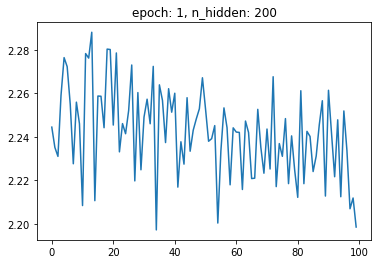

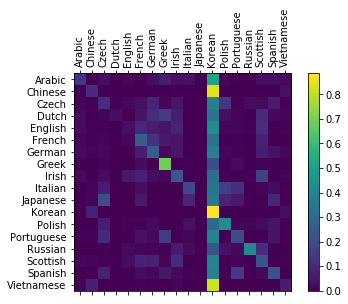

5000 5% (24m 18s) 0.8171 Vincent / French ✓
10000 10% (24m 49s) 1.9522 Mao / Chinese ✓
15000 15% (25m 20s) 2.5106 Johnston / Korean ✗ (Scottish)
20000 20% (25m 51s) 2.8492 Jez / Vietnamese ✗ (Polish)
25000 25% (26m 22s) 2.0253 Shin / Vietnamese ✗ (Korean)
30000 30% (26m 53s) 1.2825 Yap / Korean ✗ (Chinese)
35000 35% (27m 23s) 2.0343 Lis / Vietnamese ✗ (Polish)
40000 40% (27m 54s) 2.3402 Gorka / Korean ✗ (Polish)
45000 45% (28m 33s) 1.9778 Luong / Chinese ✗ (Vietnamese)
50000 50% (29m 8s) 2.2347 Lyon / Korean ✗ (English)
55000 55% (29m 43s) 1.5775 Mar / Chinese ✓
60000 60% (30m 16s) 1.8088 Neale / Vietnamese ✗ (English)
65000 65% (30m 47s) 3.1541 Rallis / Chinese ✗ (Greek)
70000 70% (31m 19s) 2.1774 Ross / Chinese ✗ (Scottish)
75000 75% (31m 52s) 1.8603 Mai / Chinese ✗ (Vietnamese)
80000 80% (32m 24s) 2.1558 Seeger / Korean ✗ (Dutch)
85000 85% (32m 56s) 2.3039 Wood / Korean ✗ (Scottish)
90000 90% (33m 29s) 3.2692 Aonghus / Chinese ✗ (Irish)
95000 95% (34m 1s) 2.4976 Calpis / Vietnamese 

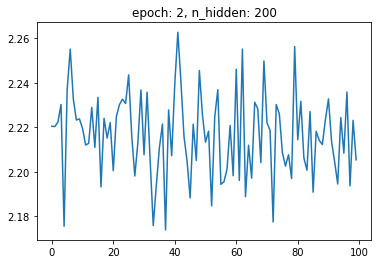

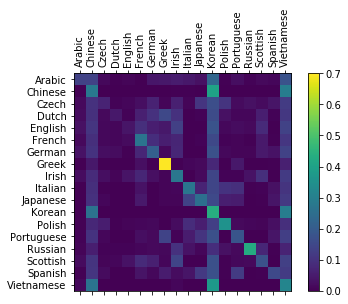

test accuracy:  0.25699999928474426
test error:  0.7430000007152557
test class wise accuracy:
Arabic 0.10782608389854431
Chinese 0.9368061423301697
Czech 0.06666667014360428
Dutch 0.02815622091293335
English 0.012998267076909542
French 0.25656741857528687
German 0.27197039127349854
Greek 0.7201793789863586
Irish 0.2785145938396454
Italian 0.4211045503616333
Japanese 0.2196219563484192
Korean 0.04507819563150406
Polish 0.35247349739074707
Portuguese 0.0459231473505497
Russian 0.4124999940395355
Scottish 0.20476610958576202
Spanish 0.15526802837848663
Vietnamese 0.05823475867509842


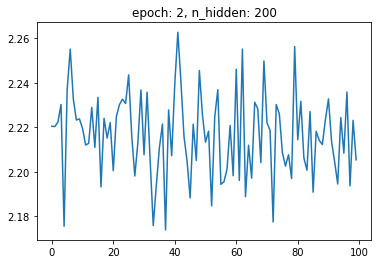

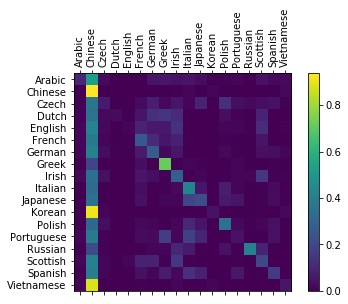

5000 5% (35m 24s) 1.2140 Roosevelt / French ✗ (Dutch)
10000 10% (35m 56s) 1.6195 Conchobhar / Chinese ✗ (Irish)
15000 15% (36m 28s) 1.9285 Zhai / Chinese ✓
20000 20% (36m 59s) 1.1724 Houtum / Arabic ✗ (Dutch)
25000 25% (37m 30s) 2.1925 Haik / Chinese ✗ (Arabic)
30000 30% (38m 3s) 2.1172 Son / Chinese ✗ (Korean)
35000 35% (38m 35s) 2.4640 Costa / Chinese ✗ (Portuguese)
40000 40% (39m 7s) 1.9290 Werlla / Chinese ✗ (Czech)
45000 45% (39m 39s) 1.4923 Duerr / Chinese ✗ (German)
50000 50% (40m 11s) 2.2921 Buckley / Chinese ✗ (English)
55000 55% (40m 42s) 2.1186 Cruz / Korean ✗ (Portuguese)
60000 60% (41m 14s) 2.6642 Kaczka / Chinese ✗ (Polish)
65000 65% (41m 46s) 3.6199 Adami / Korean ✗ (Italian)
70000 70% (42m 18s) 2.0207 Gomes / Chinese ✗ (Portuguese)
75000 75% (42m 51s) 2.5986 Pham / Korean ✗ (Vietnamese)
80000 80% (43m 22s) 2.1675 Rim / Chinese ✗ (Korean)
85000 85% (43m 55s) 2.5822 Rodagh / Chinese ✗ (Irish)
90000 90% (44m 29s) 2.7787 Abraham / Chinese ✗ (French)
95000 95% (45m 2s) 2.475

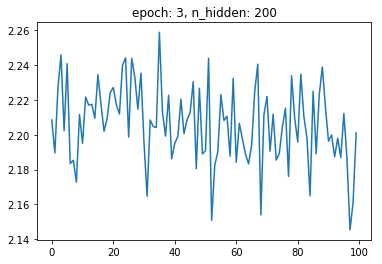

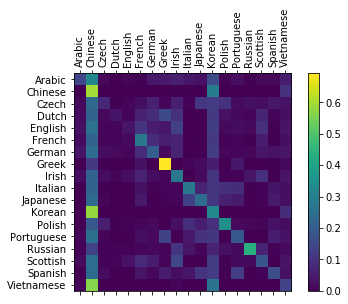

test accuracy:  0.2639000117778778
test error:  0.7360999882221222
test class wise accuracy:
Arabic 0.2309090942144394
Chinese 0.0809859186410904
Czech 0.019266055896878242
Dutch 0.03778558969497681
English 0.023741690441966057
French 0.31138288974761963
German 0.08435852080583572
Greek 0.6449016332626343
Irish 0.3711985647678375
Italian 0.16175156831741333
Japanese 0.22637979686260223
Korean 0.9230769276618958
Polish 0.4443493187427521
Portuguese 0.2623853087425232
Russian 0.48808473348617554
Scottish 0.10303588211536407
Spanish 0.15718157589435577
Vietnamese 0.11100917309522629


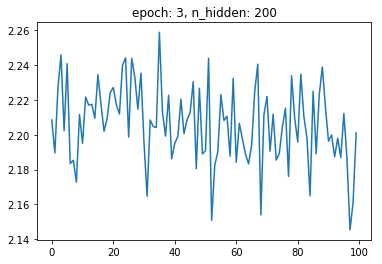

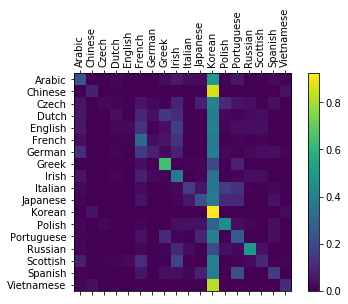

5000 5% (46m 39s) 1.5149 Franco / Korean ✗ (Portuguese)
10000 10% (47m 15s) 2.7104 Cao / Korean ✗ (Vietnamese)
15000 15% (47m 49s) 1.5318 Ma / Korean ✗ (Vietnamese)
20000 20% (48m 22s) 2.4550 Abboud / Korean ✗ (Arabic)
25000 25% (48m 56s) 1.2603 Chaput / French ✓
30000 30% (49m 31s) 1.3262 Maalouf / Polish ✗ (Arabic)
35000 35% (50m 3s) 2.2137 Limoshin / Chinese ✗ (Russian)
40000 40% (50m 35s) 2.2758 Thao / Chinese ✗ (Vietnamese)
45000 45% (51m 6s) 2.1990 Ta / Korean ✗ (Vietnamese)
50000 50% (51m 38s) 2.2141 Penzig / Korean ✗ (German)
55000 55% (52m 10s) 1.9565 Quinlivan / Korean ✗ (English)
60000 60% (52m 43s) 1.9453 Yun / Korean ✓
65000 65% (53m 15s) 2.4169 Glatter / Korean ✗ (Czech)
70000 70% (53m 49s) 1.1410 Yin / Korean ✗ (Chinese)
75000 75% (54m 22s) 2.2646 Huang / Korean ✗ (Chinese)
80000 80% (54m 54s) 2.3516 Chew / Korean ✗ (Chinese)
85000 85% (55m 26s) 2.4206 Fionn / Korean ✗ (Irish)
90000 90% (55m 58s) 2.0803 Fabian / Korean ✗ (Polish)
95000 95% (56m 31s) 2.0974 Leitzke / Viet

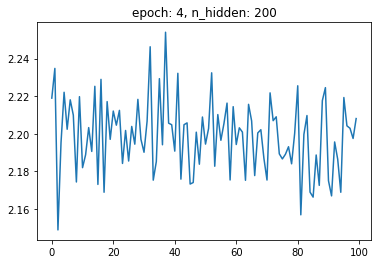

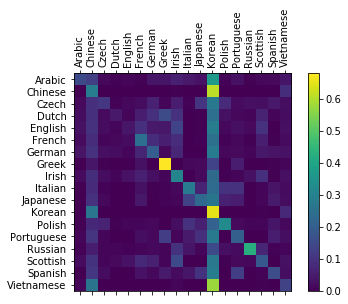

test accuracy:  0.2651500105857849
test error:  0.7348499894142151
test class wise accuracy:
Arabic 0.15117289125919342
Chinese 0.10577777773141861
Czech 0.11795316636562347
Dutch 0.042348410934209824
English 0.04649042710661888
French 0.1698455959558487
German 0.2082585245370865
Greek 0.6566265225410461
Irish 0.3239564299583435
Italian 0.2652134299278259
Japanese 0.2257194221019745
Korean 0.9099650382995605
Polish 0.33640551567077637
Portuguese 0.27321910858154297
Russian 0.4845454692840576
Scottish 0.19856244325637817
Spanish 0.14412811398506165
Vietnamese 0.06741572916507721


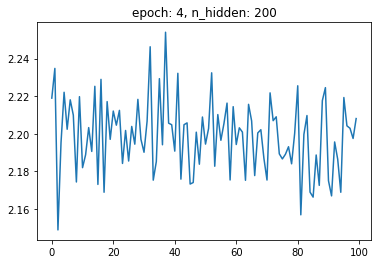

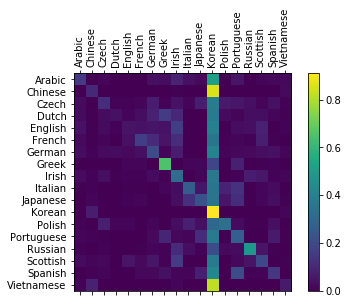

5000 5% (57m 54s) 2.4556 Marino / Korean ✗ (Spanish)
10000 10% (58m 26s) 1.9611 Donoghue / Korean ✗ (Irish)
15000 15% (58m 56s) 2.4047 MaxaB / Korean ✗ (Czech)
20000 20% (59m 27s) 1.8935 Rijnders / Greek ✗ (Dutch)
25000 25% (59m 58s) 2.2964 Borowski / Italian ✗ (Czech)
30000 30% (60m 29s) 2.6349 Milne / Chinese ✗ (Scottish)
35000 35% (60m 59s) 2.3141 Lestrange / Chinese ✗ (French)
40000 40% (61m 30s) 2.6090 Glockl / Chinese ✗ (Czech)
45000 45% (62m 1s) 1.6169 Do / Korean ✗ (Vietnamese)
50000 50% (62m 33s) 1.6484 Huie / Chinese ✓
55000 55% (63m 8s) 2.4172 Pey / Chinese ✗ (Dutch)
60000 60% (63m 43s) 2.5353 Avvakumov / Chinese ✗ (Russian)
65000 65% (64m 18s) 2.2288 Jamieson / Chinese ✗ (Scottish)
70000 70% (64m 53s) 2.4948 Ooka / Korean ✗ (Japanese)
75000 75% (65m 28s) 2.0537 Cao / Vietnamese ✓
80000 80% (66m 3s) 1.8799 Serafim / Chinese ✗ (Portuguese)
85000 85% (66m 39s) 1.5971 Baba / Chinese ✗ (Arabic)
90000 90% (67m 14s) 2.6186 Venne / Korean ✗ (Dutch)
95000 95% (67m 49s) 1.3478 Quang 

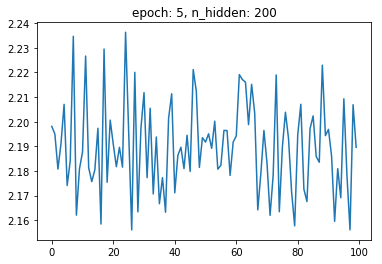

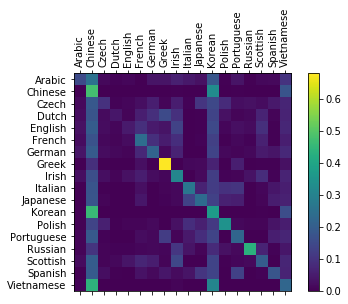

test accuracy:  0.2644999921321869
test error:  0.7355000078678131
test class wise accuracy:
Arabic 0.13459879159927368
Chinese 0.9576427340507507
Czech 0.08415398746728897
Dutch 0.04477611929178238
English 0.015329125337302685
French 0.3970964848995209
German 0.14972776174545288
Greek 0.678438663482666
Irish 0.3404255211353302
Italian 0.2995348870754242
Japanese 0.09798534959554672
Korean 0.056338027119636536
Polish 0.38391223549842834
Portuguese 0.22159090638160706
Russian 0.40561896562576294
Scottish 0.23083779215812683
Spanish 0.23070017993450165
Vietnamese 0.05806451663374901


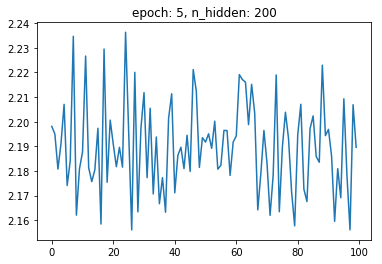

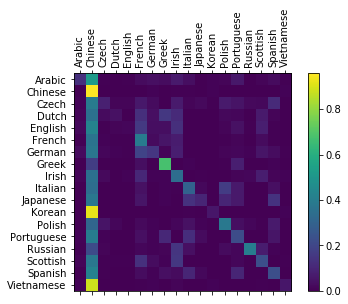

5000 5% (69m 19s) 3.9115 Shaiewich / Korean ✗ (Russian)
10000 10% (69m 51s) 2.8248 Fabre / French ✓
15000 15% (70m 21s) 1.6504 Choi / Korean ✓
20000 20% (70m 52s) 2.1065 an / Korean ✗ (Vietnamese)
25000 25% (71m 22s) 2.8164 Jackson / Vietnamese ✗ (Scottish)
30000 30% (71m 52s) 2.0497 Gerst / Scottish ✗ (German)
35000 35% (72m 23s) 1.7194 Tommii / Vietnamese ✗ (Japanese)
40000 40% (72m 53s) 2.7004 Sula / Korean ✗ (Czech)
45000 45% (73m 24s) 2.7756 Roma / Korean ✗ (Italian)
50000 50% (73m 54s) 2.3812 Basurto / Vietnamese ✗ (Portuguese)
55000 55% (74m 28s) 1.6102 Nghiem / Arabic ✗ (Vietnamese)
60000 60% (75m 1s) 2.3879 Foss / Korean ✗ (French)
65000 65% (75m 33s) 2.2566 Phan / Chinese ✗ (Vietnamese)
70000 70% (76m 7s) 1.8675 Ross / Chinese ✗ (Scottish)
75000 75% (76m 40s) 2.0470 Pape / Korean ✗ (French)
80000 80% (77m 13s) 2.8163 Snijder / Korean ✗ (Dutch)
85000 85% (77m 46s) 2.6712 Fini / Korean ✗ (Italian)
90000 90% (78m 19s) 2.2104 Doan / Chinese ✗ (Vietnamese)
95000 95% (78m 52s) 1.98

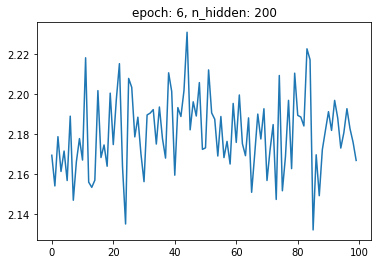

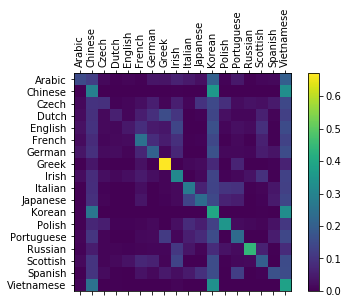

test accuracy:  0.2651500105857849
test error:  0.7348499894142151
test class wise accuracy:
Arabic 0.15433213114738464
Chinese 0.1111111119389534
Czech 0.053275108337402344
Dutch 0.0672566369175911
English 0.07407407462596893
French 0.2322695106267929
German 0.18621307611465454
Greek 0.628731369972229
Irish 0.3373161852359772
Italian 0.2670068144798279
Japanese 0.2925989627838135
Korean 0.8993929028511047
Polish 0.39447906613349915
Portuguese 0.28358209133148193
Russian 0.39981186389923096
Scottish 0.20979666709899902
Spanish 0.11651375889778137
Vietnamese 0.05882352963089943


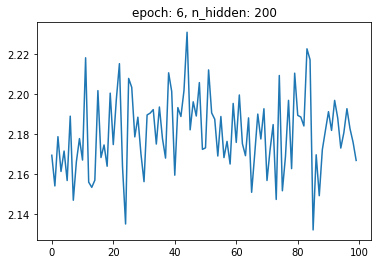

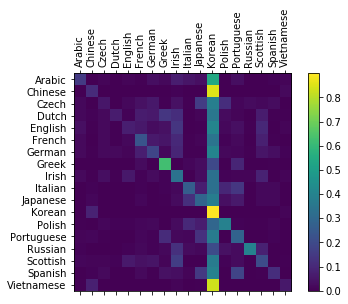

5000 5% (1m 8s) 2.8749 Lee / Vietnamese ✗ (Korean)
10000 10% (2m 15s) 2.8348 Yau / Vietnamese ✗ (Chinese)
15000 15% (3m 23s) 2.9163 Pace / Vietnamese ✗ (Italian)
20000 20% (4m 32s) 2.8756 Choi / Korean ✓
25000 25% (5m 41s) 2.8768 Dai / Arabic ✗ (Chinese)
30000 30% (6m 52s) 2.7857 Ding / Korean ✗ (Chinese)
35000 35% (8m 2s) 2.8210 Sun / Vietnamese ✗ (Korean)
40000 40% (9m 11s) 2.8701 Koza / Korean ✗ (Czech)
45000 45% (10m 15s) 2.6237 Jon / Korean ✓
50000 50% (11m 25s) 2.8645 Woo / Vietnamese ✗ (Korean)
55000 55% (12m 35s) 2.9487 Quan / Vietnamese ✗ (Chinese)
60000 60% (13m 45s) 2.8415 Janz / Arabic ✗ (German)
65000 65% (14m 50s) 2.9141 Thach / Arabic ✗ (Vietnamese)
70000 70% (15m 47s) 2.6642 Vo / Chinese ✗ (Vietnamese)
75000 75% (16m 44s) 2.8699 Koga / Vietnamese ✗ (Japanese)
80000 80% (17m 40s) 2.6093 Ma / Korean ✗ (Vietnamese)
85000 85% (18m 36s) 2.6154 Chu / Korean ✗ (Vietnamese)
90000 90% (19m 32s) 2.5170 Ahn / Chinese ✗ (Korean)
95000 95% (20m 29s) 2.9194 Abt / Arabic ✗ (German)
10

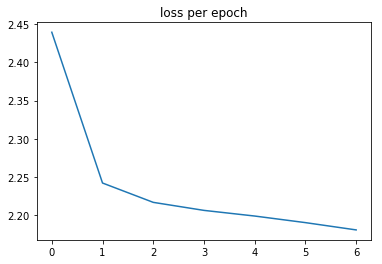

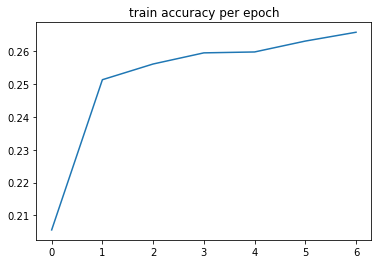

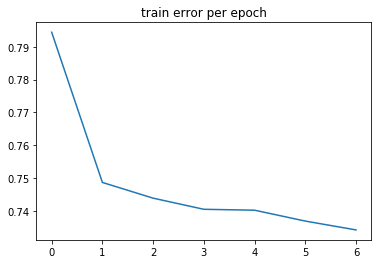

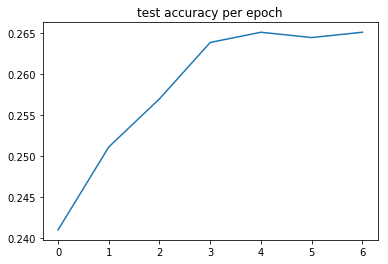

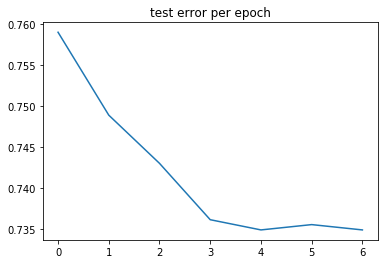

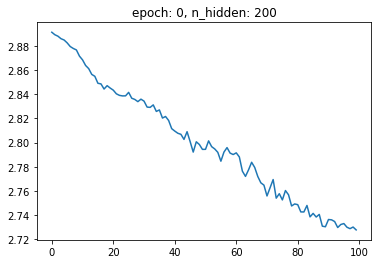

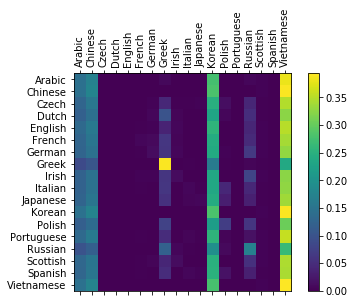

test accuracy:  0.1171099990606308
test error:  0.8828900009393692
test class wise accuracy:
Arabic 0.0
Chinese 1.0
Czech 0.0
Dutch 0.014492753893136978
English 0.0
French 0.05474254861474037
German 0.05348919704556465
Greek 0.3991031348705292
Irish 0.1136741116642952
Italian 0.048269741237163544
Japanese 0.06409560143947601
Korean 0.0
Polish 0.18216148018836975
Portuguese 0.0
Russian 0.18549686670303345
Scottish 0.0
Spanish 0.0
Vietnamese 0.0


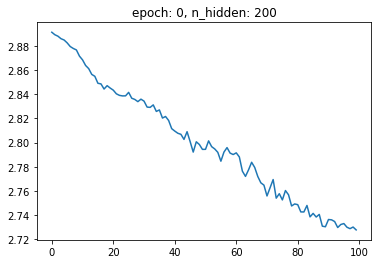

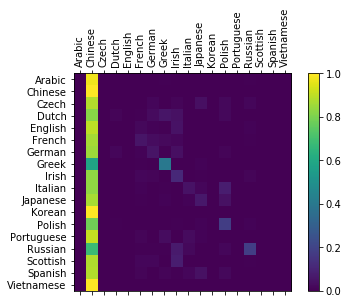

5000 5% (23m 1s) 2.7514 Luu / Korean ✗ (Vietnamese)
10000 10% (23m 56s) 2.8748 Lac / Chinese ✗ (Vietnamese)
15000 15% (24m 52s) 2.6775 Ko / Korean ✓
20000 20% (25m 47s) 2.7823 Solo / Korean ✗ (Spanish)
25000 25% (26m 43s) 2.7828 Pho / Korean ✗ (Vietnamese)
30000 30% (27m 39s) 2.7494 Jo / Vietnamese ✗ (Korean)
35000 35% (28m 35s) 2.8300 Ha / Vietnamese ✗ (Korean)
40000 40% (29m 31s) 2.7043 Pho / Chinese ✗ (Vietnamese)
45000 45% (30m 27s) 2.5998 Vuu / Korean ✗ (Vietnamese)
50000 50% (31m 23s) 2.5717 Wood / Korean ✗ (Scottish)
55000 55% (32m 19s) 2.8129 Jo / Vietnamese ✗ (Korean)
60000 60% (33m 15s) 2.5365 Ho / Vietnamese ✗ (Korean)
65000 65% (34m 11s) 2.7430 Mas / Vietnamese ✗ (German)
70000 70% (35m 7s) 2.3995 Sin / Chinese ✗ (Korean)
75000 75% (36m 3s) 2.7478 Than / Korean ✗ (Vietnamese)
80000 80% (37m 0s) 2.8151 Ha / Korean ✓
85000 85% (37m 56s) 2.6984 Heel / Korean ✗ (Dutch)
90000 90% (38m 53s) 2.6483 Ponec / Korean ✗ (Czech)
95000 95% (39m 49s) 3.0399 Dupond / Korean ✗ (French)
1000

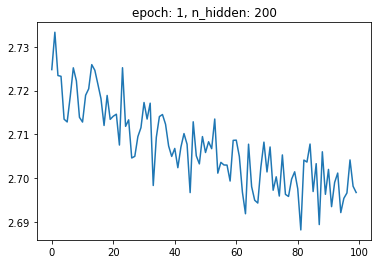

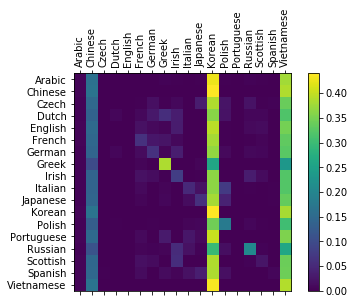

test accuracy:  0.1204100027680397
test error:  0.8795899972319603
test class wise accuracy:
Arabic 0.0
Chinese 0.0
Czech 0.00498575484380126
Dutch 0.027240144088864326
English 0.0
French 0.06922660768032074
German 0.049021366983652115
Greek 0.3897019922733307
Irish 0.08523453027009964
Italian 0.03181980550289154
Japanese 0.05475810915231705
Korean 0.99981689453125
Polish 0.17789071798324585
Portuguese 0.0
Russian 0.20230473577976227
Scottish 0.059067919850349426
Spanish 0.029432624578475952
Vietnamese 0.0


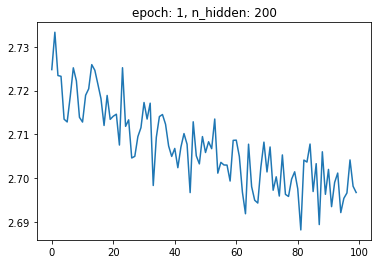

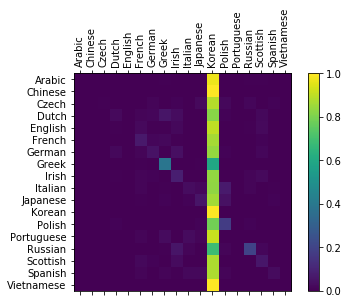

5000 5% (42m 20s) 2.7636 Gil / Korean ✓
10000 10% (43m 16s) 2.7126 Hertz / Arabic ✗ (German)
15000 15% (44m 13s) 2.7319 Kwak / Chinese ✗ (Korean)
20000 20% (45m 9s) 2.7996 Ono / Chinese ✗ (Japanese)
25000 25% (46m 5s) 2.5625 Chu / Vietnamese ✓
30000 30% (47m 0s) 2.4950 Si / Chinese ✗ (Korean)
35000 35% (47m 56s) 2.5899 Ba / Chinese ✗ (Arabic)
40000 40% (48m 52s) 2.9165 Ha / Arabic ✗ (Korean)
45000 45% (49m 48s) 2.8842 Pey / Chinese ✗ (Dutch)
50000 50% (50m 44s) 2.8078 Ku / Chinese ✗ (Korean)
55000 55% (51m 39s) 2.7038 Song / Vietnamese ✗ (Korean)
60000 60% (52m 36s) 2.6077 Vo / Vietnamese ✓
65000 65% (53m 32s) 2.6175 Van / Vietnamese ✓
70000 70% (54m 27s) 2.5846 Do / Vietnamese ✓
75000 75% (55m 23s) 2.6399 Shi / Korean ✗ (Chinese)
80000 80% (56m 20s) 2.8300 Long / Vietnamese ✗ (Chinese)
85000 85% (57m 15s) 2.5613 Chi / Korean ✓
90000 90% (58m 11s) 2.6823 Ho / Vietnamese ✓
95000 95% (59m 7s) 2.8330 Ha / Korean ✓
100000 100% (60m 3s) 2.6941 Chau / Vietnamese ✓
tensor(121509.)
train accur

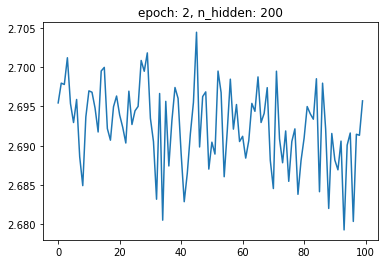

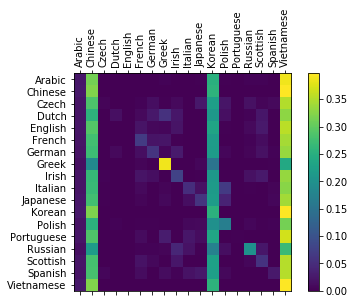

test accuracy:  0.12416000664234161
test error:  0.8758399933576584
test class wise accuracy:
Arabic 0.0
Chinese 0.0
Czech 0.006048386916518211
Dutch 0.012714900076389313
English 0.0
French 0.069626085460186
German 0.055956680327653885
Greek 0.3934485912322998
Irish 0.07627573609352112
Italian 0.04216431453824043
Japanese 0.0567677840590477
Korean 0.0
Polish 0.180145725607872
Portuguese 0.007805409375578165
Russian 0.20114633440971375
Scottish 0.06939724832773209
Spanish 0.040051206946372986
Vietnamese 0.9996505379676819


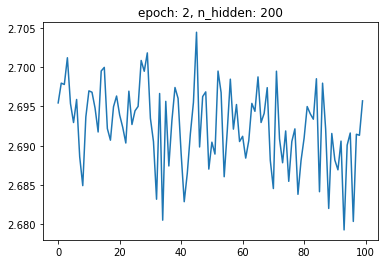

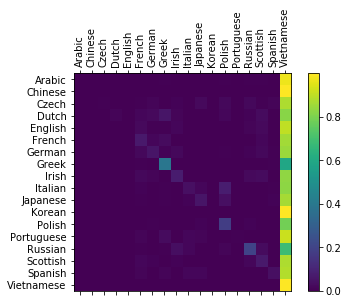

5000 5% (61m 39s) 2.7201 Cote / Vietnamese ✗ (French)
10000 10% (62m 38s) 2.6909 Chu / Korean ✗ (Vietnamese)
15000 15% (63m 35s) 2.6245 Guo / Chinese ✓
20000 20% (64m 31s) 2.7857 Pak / Vietnamese ✗ (Korean)
25000 25% (65m 27s) 2.7503 Rana / Chinese ✗ (Spanish)
30000 30% (66m 24s) 2.9687 San / Korean ✓
35000 35% (67m 19s) 2.8361 Yeo / Arabic ✗ (Korean)
40000 40% (68m 15s) 3.0324 Xin / Chinese ✓
45000 45% (69m 11s) 2.7259 Hazov / Vietnamese ✗ (Russian)
50000 50% (70m 7s) 2.6877 Hiu / Chinese ✓
55000 55% (71m 3s) 2.8097 Tao / Korean ✗ (Chinese)
60000 60% (71m 59s) 2.7187 Ku / Korean ✓
65000 65% (72m 54s) 2.6771 Lyon / Vietnamese ✗ (French)
70000 70% (73m 50s) 2.8105 Aart / Chinese ✗ (Dutch)
75000 75% (74m 46s) 2.6638 Nam / Chinese ✗ (Korean)
80000 80% (75m 41s) 2.4882 Tow / Korean ✗ (Chinese)
85000 85% (76m 37s) 2.8967 Srour / Vietnamese ✗ (Arabic)
90000 90% (77m 33s) 2.6443 Vigo / Chinese ✗ (Italian)
95000 95% (78m 30s) 2.7883 Si / Vietnamese ✗ (Korean)
100000 100% (79m 26s) 2.8256 Baik 

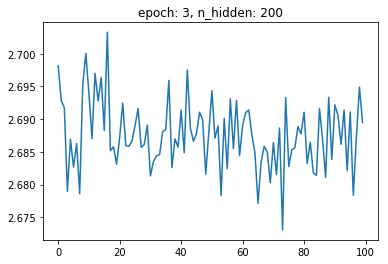

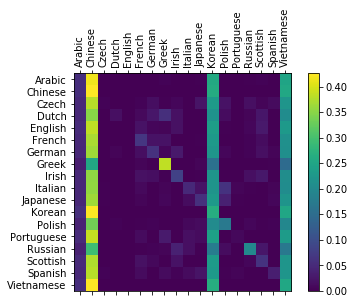

test accuracy:  0.12351000308990479
test error:  0.8764899969100952
test class wise accuracy:
Arabic 0.0
Chinese 1.0
Czech 0.0018011527135968208
Dutch 0.0066956207156181335
English 0.0
French 0.05739959701895714
German 0.07151752710342407
Greek 0.3842039704322815
Irish 0.08373294025659561
Italian 0.03928888961672783
Japanese 0.06052963435649872
Korean 0.0
Polish 0.17832355201244354
Portuguese 0.014516721479594707
Russian 0.20331186056137085
Scottish 0.06637246161699295
Spanish 0.04509522020816803
Vietnamese 0.0


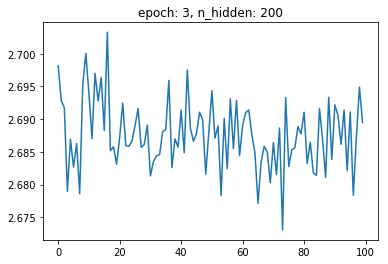

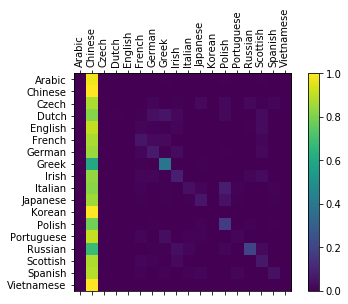

5000 5% (81m 1s) 2.8457 Melo / Chinese ✗ (Portuguese)
10000 10% (81m 57s) 2.7308 Qiu / Vietnamese ✗ (Chinese)
15000 15% (82m 54s) 2.8229 Jang / Chinese ✗ (Korean)
20000 20% (83m 50s) 2.9799 Vinh / Vietnamese ✓
25000 25% (84m 46s) 2.5010 Suk / Korean ✓
30000 30% (85m 42s) 2.7172 Yu / Korean ✓
35000 35% (86m 39s) 2.6295 Suh / Chinese ✗ (Korean)
40000 40% (87m 35s) 2.5508 Ly / Korean ✗ (Vietnamese)
45000 45% (88m 31s) 2.3681 Roach / Korean ✗ (Irish)
50000 50% (89m 27s) 2.9515 Luc / Vietnamese ✓
55000 55% (90m 23s) 2.6998 Hou / Vietnamese ✗ (Chinese)
60000 60% (91m 19s) 2.9506 Shu / Chinese ✓
65000 65% (92m 16s) 2.7563 White / Chinese ✗ (Scottish)
70000 70% (93m 12s) 2.6782 Kan / Korean ✗ (Dutch)
75000 75% (94m 9s) 2.6977 Dana / Chinese ✗ (Czech)
80000 80% (95m 5s) 2.6598 Hiu / Chinese ✓
85000 85% (96m 1s) 2.6210 Kato / Chinese ✗ (Japanese)
90000 90% (96m 59s) 2.6852 Vu / Korean ✗ (Vietnamese)
95000 95% (98m 4s) 2.7241 Toma / Vietnamese ✗ (Arabic)
100000 100% (99m 0s) 2.5793 Lu / Korean ✗ 

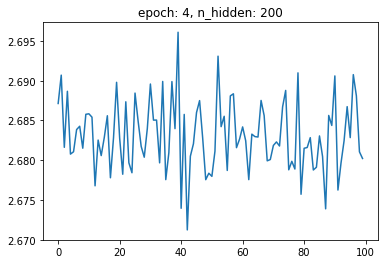

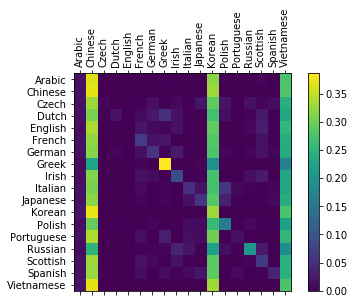

test accuracy:  0.12443999946117401
test error:  0.875560000538826
test class wise accuracy:
Arabic 0.00017433751781936735
Chinese 0.0
Czech 0.0036251586861908436
Dutch 0.012459950521588326
English 0.00017761989147402346
French 0.06517094373703003
German 0.07806215435266495
Greek 0.3865997791290283
Irish 0.09404849261045456
Italian 0.05274488776922226
Japanese 0.06090909242630005
Korean 1.0
Polish 0.17078770697116852
Portuguese 0.018435653299093246
Russian 0.19593872129917145
Scottish 0.0615384615957737
Spanish 0.0467115081846714
Vietnamese 0.0


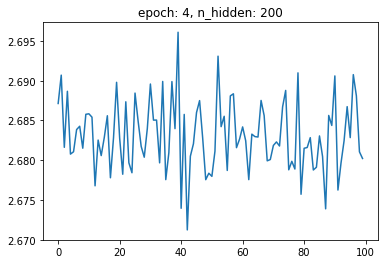

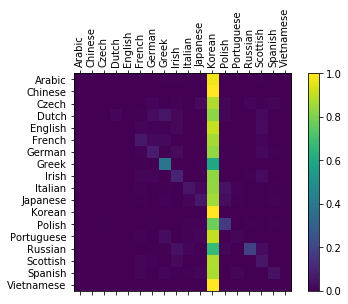

5000 5% (100m 36s) 2.6197 Melo / Chinese ✗ (Portuguese)
10000 10% (101m 32s) 2.7879 An / Vietnamese ✓
15000 15% (102m 28s) 2.4234 Rog / Chinese ✗ (Polish)
20000 20% (103m 23s) 2.6006 Yin / Chinese ✓
25000 25% (104m 19s) 2.6623 Lu / Chinese ✓
30000 30% (105m 16s) 2.8488 Vela / Chinese ✗ (Spanish)
35000 35% (106m 12s) 2.7035 Lim / Chinese ✓
40000 40% (107m 8s) 2.7411 Hajjar / Chinese ✗ (Arabic)
45000 45% (108m 4s) 2.6426 Le / Chinese ✗ (Vietnamese)
50000 50% (109m 0s) 2.7205 Thi / Chinese ✗ (Vietnamese)
55000 55% (109m 56s) 2.6424 Cao / Vietnamese ✓
60000 60% (110m 51s) 2.8077 Ma / Arabic ✗ (Korean)
65000 65% (111m 47s) 3.0230 Noh / Chinese ✗ (Korean)
70000 70% (112m 43s) 2.6872 Zino / Korean ✗ (Italian)
75000 75% (113m 38s) 2.7615 Ton / Vietnamese ✓
80000 80% (114m 35s) 2.8066 Ho / Korean ✓
85000 85% (115m 31s) 2.8847 Gomes / Vietnamese ✗ (Portuguese)
90000 90% (116m 26s) 2.7259 Mas / Korean ✗ (Dutch)
95000 95% (117m 22s) 2.7035 So / Korean ✓
100000 100% (118m 18s) 2.7719 Ton / Arabic ✗

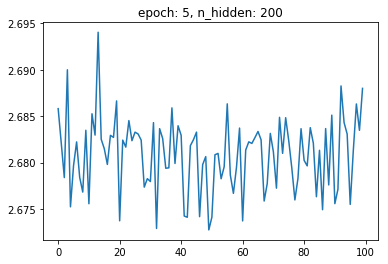

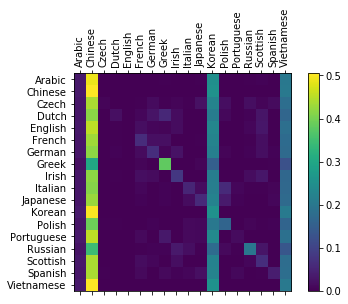

test accuracy:  0.12072999775409698
test error:  0.879270002245903
test class wise accuracy:
Arabic 0.9775704145431519
Chinese 0.0
Czech 0.012811259366571903
Dutch 0.01981457881629467
English 0.0
French 0.06695542484521866
German 0.057705964893102646
Greek 0.37599998712539673
Irish 0.09698392450809479
Italian 0.06121714040637016
Japanese 0.0801834836602211
Korean 0.0
Polish 0.11077308654785156
Portuguese 0.01911976933479309
Russian 0.22696276009082794
Scottish 0.03144311159849167
Spanish 0.030821917578577995
Vietnamese 0.0


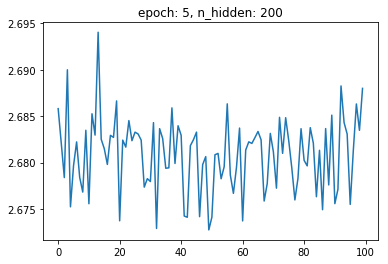

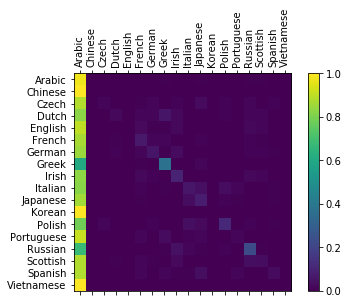

5000 5% (119m 53s) 2.8480 Tron / Vietnamese ✓
10000 10% (120m 49s) 2.7450 Tron / Vietnamese ✓
15000 15% (121m 44s) 2.6750 Cai / Korean ✗ (Chinese)
20000 20% (122m 40s) 2.6094 Ha / Chinese ✗ (Korean)
25000 25% (123m 36s) 2.8140 Pho / Chinese ✗ (Vietnamese)
30000 30% (124m 32s) 2.5927 Sai / Chinese ✗ (Vietnamese)
35000 35% (125m 28s) 2.7382 Lam / Chinese ✗ (Vietnamese)
40000 40% (126m 24s) 2.9696 So / Chinese ✗ (Korean)
45000 45% (127m 20s) 2.3643 Toal / Korean ✗ (English)
50000 50% (128m 16s) 2.3159 Jon / Vietnamese ✗ (Korean)
55000 55% (129m 12s) 2.6529 Munro / Korean ✗ (Scottish)
60000 60% (130m 8s) 2.5551 Vo / Vietnamese ✓
65000 65% (131m 3s) 2.5990 Fei / Arabic ✗ (Chinese)
70000 70% (131m 59s) 2.3627 Dong / Chinese ✓
75000 75% (132m 54s) 2.8750 Duong / Chinese ✗ (Vietnamese)
80000 80% (133m 50s) 2.7762 Yeo / Korean ✓
85000 85% (134m 46s) 2.6882 Hong / Vietnamese ✗ (Chinese)
90000 90% (135m 41s) 2.6272 Son / Chinese ✗ (Korean)
95000 95% (136m 38s) 2.4793 Tuma / Korean ✗ (Arabic)
1000

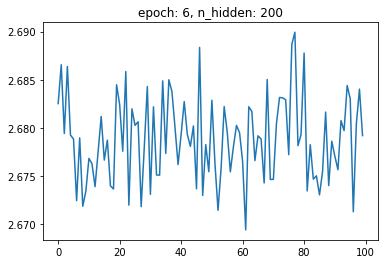

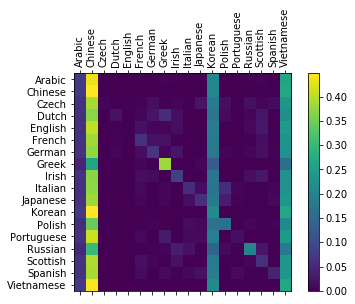

test accuracy:  0.12287000566720963
test error:  0.8771299943327904
test class wise accuracy:
Arabic 0.0009134088177233934
Chinese 0.0
Czech 0.009316770359873772
Dutch 0.021956443786621094
English 0.0
French 0.0544818714261055
German 0.07297971099615097
Greek 0.38441935181617737
Irish 0.06253398954868317
Italian 0.05732369050383568
Japanese 0.059332508593797684
Korean 0.999636709690094
Polish 0.15568098425865173
Portuguese 0.02059248462319374
Russian 0.23386512696743011
Scottish 0.052483268082141876
Spanish 0.041047416627407074
Vietnamese 0.0


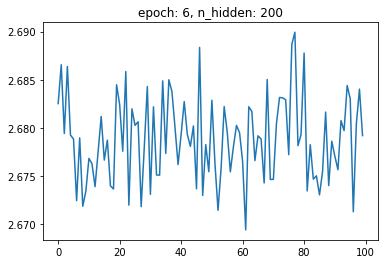

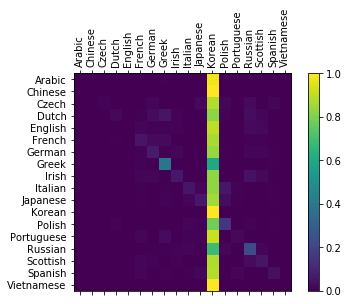

5000 5% (1m 49s) 2.8941 Yeo / Greek ✗ (Korean)
10000 10% (3m 36s) 2.8908 Ba / Portuguese ✗ (Arabic)
15000 15% (5m 24s) 2.8915 Ra / Irish ✗ (Korean)
20000 20% (7m 12s) 2.8835 Yi / Portuguese ✗ (Korean)
25000 25% (9m 0s) 2.8433 Mac / Portuguese ✗ (English)
30000 30% (10m 47s) 2.8304 Ko / Portuguese ✗ (Korean)
35000 35% (12m 36s) 2.8668 Hua / Scottish ✗ (Chinese)
40000 40% (14m 24s) 2.9026 Le / Arabic ✗ (Vietnamese)
45000 45% (16m 13s) 2.8805 Chu / Chinese ✗ (Vietnamese)
50000 50% (18m 1s) 2.8656 Lac / Korean ✗ (Vietnamese)
55000 55% (19m 49s) 2.7990 Cruz / Chinese ✗ (Portuguese)
60000 60% (21m 37s) 2.8852 Re / Chinese ✗ (Italian)
65000 65% (23m 26s) 2.8570 Ha / Arabic ✗ (Korean)
70000 70% (25m 15s) 2.8399 Phi / Vietnamese ✓
75000 75% (27m 4s) 2.8683 Ho / Chinese ✗ (Korean)
80000 80% (28m 53s) 2.7458 Ha / Vietnamese ✗ (Korean)
85000 85% (30m 41s) 2.8382 Ba / Korean ✗ (Arabic)
90000 90% (32m 28s) 2.8493 La / Chinese ✗ (Vietnamese)
95000 95% (34m 16s) 2.8440 Yu / Chinese ✗ (Korean)
100000 1

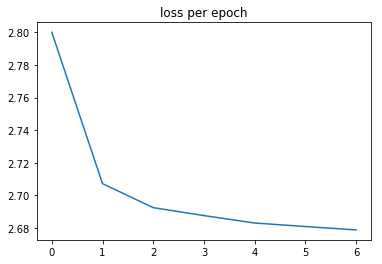

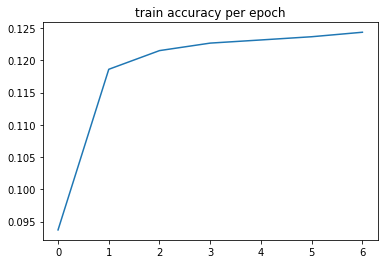

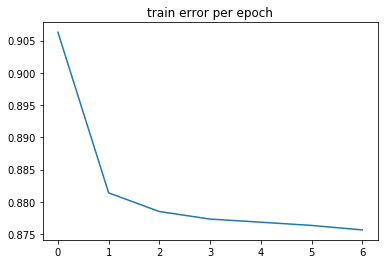

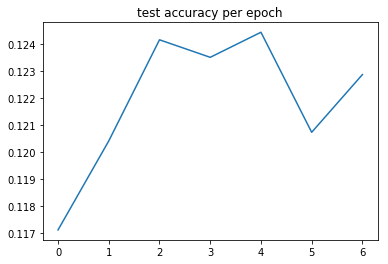

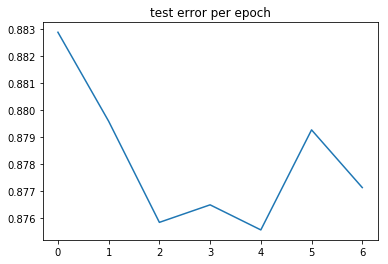

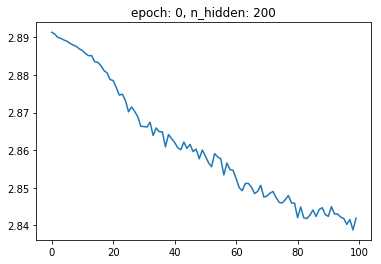

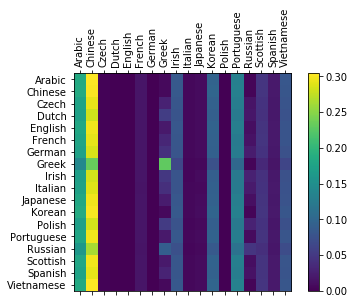

test accuracy:  0.07523667067289352
test error:  0.9247633293271065
test class wise accuracy:
Arabic 0.9997588396072388
Chinese 0.0
Czech 0.0
Dutch 0.0
English 0.0
French 0.0
German 0.0
Greek 0.22518420219421387
Irish 0.0
Italian 0.0
Japanese 0.0
Korean 0.0
Polish 0.0
Portuguese 0.0
Russian 0.13273441791534424
Scottish 0.0
Spanish 0.0
Vietnamese 0.0


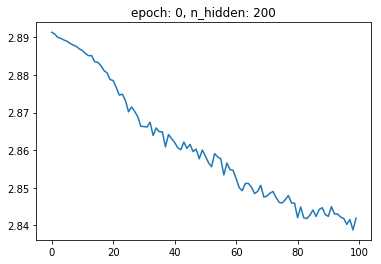

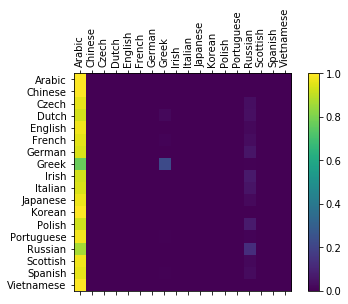

5000 5% (39m 19s) 2.8474 Ma / Korean ✗ (Vietnamese)
10000 10% (41m 8s) 2.8299 Ma / Korean ✓
15000 15% (42m 56s) 2.9045 Nam / Vietnamese ✗ (Korean)
20000 20% (44m 43s) 2.8674 An / Korean ✗ (Vietnamese)
25000 25% (46m 30s) 2.7646 Ha / Korean ✓
30000 30% (48m 19s) 2.8503 Zhu / Chinese ✓
35000 35% (50m 7s) 2.8861 La / Korean ✗ (Vietnamese)
40000 40% (51m 56s) 2.8048 Vu / Korean ✗ (Vietnamese)
45000 45% (53m 44s) 2.9794 Pan / Arabic ✗ (Chinese)
50000 50% (55m 32s) 2.8402 Oh  / Arabic ✗ (Korean)
55000 55% (57m 21s) 2.7803 Fay / Arabic ✗ (French)
60000 60% (59m 9s) 2.8731 Tan / Arabic ✗ (Chinese)
65000 65% (60m 57s) 2.8477 An / Arabic ✗ (Vietnamese)
70000 70% (62m 45s) 2.7082 Lam / Vietnamese ✓
75000 75% (64m 32s) 2.7060 Ma / Chinese ✗ (Korean)
80000 80% (66m 20s) 2.8016 Yoo / Arabic ✗ (Korean)
85000 85% (68m 9s) 2.8989 Ho / Chinese ✗ (Korean)
90000 90% (69m 57s) 2.8538 Wood / Chinese ✗ (Scottish)
95000 95% (71m 45s) 2.8045 Fei / Chinese ✓
100000 100% (73m 33s) 2.8796 Do / Chinese ✗ (Vietname

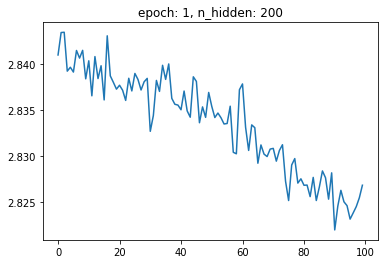

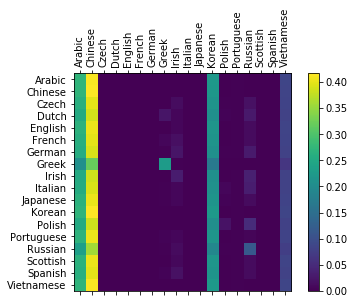

test accuracy:  0.08177333325147629
test error:  0.9182266667485237
test class wise accuracy:
Arabic 0.0
Chinese 1.0
Czech 0.0
Dutch 0.009221062995493412
English 0.0
French 0.0
German 0.0002420721430098638
Greek 0.22801752388477325
Irish 0.04800047725439072
Italian 0.0
Japanese 0.0
Korean 0.0
Polish 0.0691964253783226
Portuguese 0.0
Russian 0.10158748924732208
Scottish 0.0
Spanish 0.0
Vietnamese 0.0


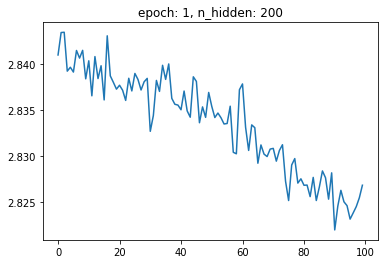

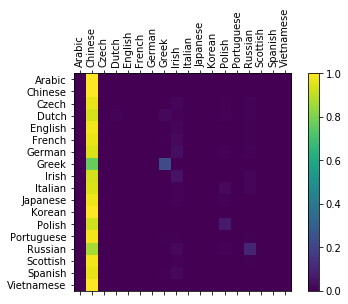

5000 5% (76m 49s) 2.8528 Yu / Chinese ✗ (Korean)
10000 10% (78m 37s) 2.7883 Suk / Vietnamese ✗ (Korean)
15000 15% (80m 25s) 2.8035 Vo / Arabic ✗ (German)
20000 20% (82m 13s) 2.8142 Liu / Arabic ✗ (Chinese)
25000 25% (84m 1s) 2.8947 Wei / Chinese ✓
30000 30% (85m 49s) 2.9317 Vu / Arabic ✗ (Vietnamese)
35000 35% (87m 38s) 2.8153 Rim / Vietnamese ✗ (Korean)
40000 40% (89m 26s) 2.8519 Sun / Vietnamese ✗ (Chinese)
45000 45% (91m 13s) 2.8217 Kron / Portuguese ✗ (German)
50000 50% (93m 2s) 2.9032 Vo / Korean ✗ (Vietnamese)
55000 55% (94m 49s) 2.8189 Abe / Vietnamese ✗ (Japanese)
60000 60% (96m 38s) 2.7023 Mai / Chinese ✗ (Vietnamese)
65000 65% (98m 25s) 2.8059 Ta / Chinese ✗ (Vietnamese)
70000 70% (100m 13s) 2.8715 Ha / Arabic ✗ (Vietnamese)
75000 75% (102m 1s) 2.7953 Vu / Arabic ✗ (Vietnamese)
80000 80% (103m 48s) 2.7610 Phi / Arabic ✗ (Vietnamese)
85000 85% (105m 37s) 2.7948 Ha / Arabic ✗ (Korean)
90000 90% (107m 24s) 2.8919 Sai / Chinese ✗ (Vietnamese)
95000 95% (109m 12s) 2.7696 Luc / Chi

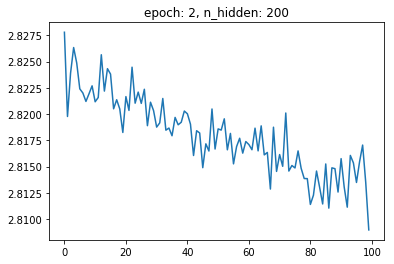

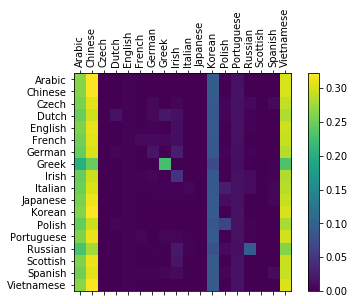

test accuracy:  0.0838533341884613
test error:  0.9161466658115387
test class wise accuracy:
Arabic 0.999759316444397
Chinese 0.0
Czech 0.0007913318695500493
Dutch 0.011310428380966187
English 0.0
French 0.01825782284140587
German 0.02506779134273529
Greek 0.22777174413204193
Irish 0.040420953184366226
Italian 0.014630665071308613
Japanese 0.0
Korean 0.0
Polish 0.06896139681339264
Portuguese 0.0
Russian 0.0898803174495697
Scottish 0.0
Spanish 0.0154495220631361
Vietnamese 0.0


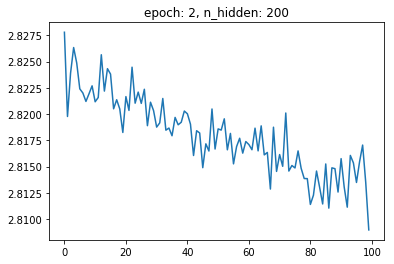

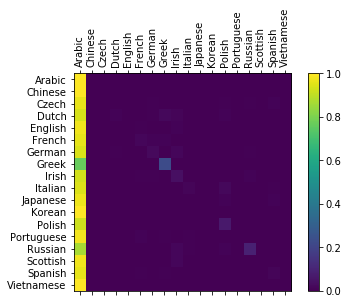

5000 5% (114m 16s) 2.7975 Ma / Chinese ✗ (Korean)
10000 10% (116m 6s) 2.7608 Yu / Arabic ✗ (Korean)
15000 15% (117m 54s) 2.8707 Hui / Arabic ✗ (Chinese)
20000 20% (119m 43s) 2.8288 Vu / Arabic ✗ (Vietnamese)
25000 25% (121m 31s) 2.8148 Ahn / Arabic ✗ (Korean)
30000 30% (123m 21s) 2.7828 Ly / Chinese ✗ (Vietnamese)
35000 35% (125m 10s) 2.8146 an / Korean ✗ (Vietnamese)
40000 40% (126m 59s) 2.7984 Shu / Vietnamese ✗ (Chinese)
45000 45% (128m 48s) 2.7923 Fan / Arabic ✗ (Chinese)
50000 50% (130m 36s) 2.7410 Lew / Arabic ✗ (Chinese)
55000 55% (132m 25s) 2.7814 Ta / Vietnamese ✓
60000 60% (134m 14s) 2.8147 Ku / Chinese ✗ (Korean)
65000 65% (136m 2s) 2.8218 Luc / Portuguese ✗ (Vietnamese)
70000 70% (137m 51s) 2.8022 Do / Vietnamese ✓
75000 75% (139m 41s) 2.7869 Le / Chinese ✗ (Vietnamese)
80000 80% (141m 30s) 2.8626 Le / Vietnamese ✓
85000 85% (143m 19s) 2.7883 Ko / Arabic ✗ (Korean)
90000 90% (145m 8s) 2.8364 Cen / Chinese ✓
95000 95% (146m 57s) 2.7967 Le / Vietnamese ✓
100000 100% (148m 46s

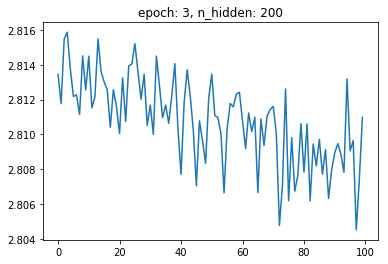

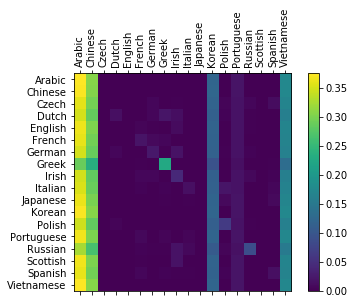

test accuracy:  0.08511999994516373
test error:  0.9148800000548363
test class wise accuracy:
Arabic 0.0
Chinese 1.0
Czech 0.0010138358920812607
Dutch 0.014684728346765041
English 0.0
French 0.01979304477572441
German 0.024854065850377083
Greek 0.22747161984443665
Irish 0.04980293661355972
Italian 0.02001953125
Japanese 0.0
Korean 0.0
Polish 0.06334053725004196
Portuguese 0.0
Russian 0.08328300714492798
Scottish 0.0
Spanish 0.013062845915555954
Vietnamese 0.0


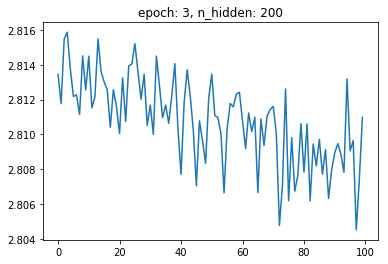

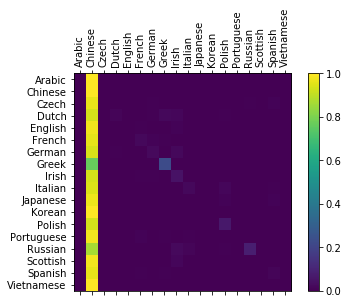

5000 5% (152m 2s) 2.8151 Gim / Vietnamese ✗ (Chinese)
10000 10% (153m 50s) 2.8003 Vu / Vietnamese ✓
15000 15% (155m 38s) 2.7970 Pae / Vietnamese ✗ (Korean)
20000 20% (157m 26s) 2.7714 Tai / Vietnamese ✗ (Chinese)
25000 25% (159m 14s) 2.8448 Koo / Arabic ✗ (Korean)
30000 30% (161m 2s) 2.8115 Rog / Vietnamese ✗ (Polish)
35000 35% (162m 50s) 2.8870 She / Vietnamese ✗ (Chinese)
40000 40% (164m 38s) 2.7661 Ma / Vietnamese ✓
45000 45% (166m 27s) 2.8310 Ryu / Arabic ✗ (Korean)
50000 50% (168m 16s) 2.8318 Bir / Korean ✗ (Russian)
55000 55% (170m 3s) 2.7933 Gu / Chinese ✗ (Korean)
60000 60% (171m 52s) 2.7827 Gu / Chinese ✗ (Korean)
65000 65% (173m 39s) 2.8053 Le / Vietnamese ✓
70000 70% (175m 26s) 2.7751 Ho / Korean ✗ (Vietnamese)
75000 75% (177m 14s) 2.8021 La / Vietnamese ✓
80000 80% (179m 1s) 2.7214 Tse / Vietnamese ✗ (Chinese)
85000 85% (180m 50s) 2.7937 Lee / Chinese ✗ (Korean)
90000 90% (182m 38s) 2.8124 Thi / Korean ✗ (Vietnamese)
95000 95% (184m 26s) 2.8505 Gu / Vietnamese ✗ (Korean)
10

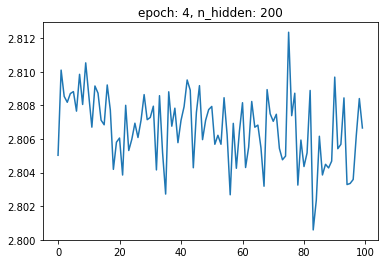

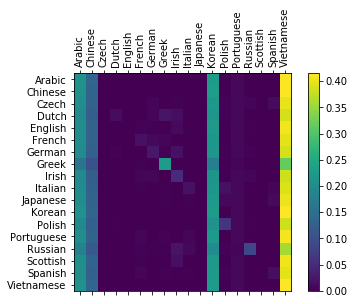

test accuracy:  0.08287666738033295
test error:  0.917123332619667
test class wise accuracy:
Arabic 0.0
Chinese 0.0
Czech 0.0005927330930717289
Dutch 0.01844225637614727
English 0.0
French 0.01987658627331257
German 0.024784935638308525
Greek 0.2259785383939743
Irish 0.039840396493673325
Italian 0.012391278520226479
Japanese 0.0
Korean 1.0
Polish 0.06170981377363205
Portuguese 0.0
Russian 0.09168688952922821
Scottish 0.0
Spanish 0.01461340393871069
Vietnamese 0.0


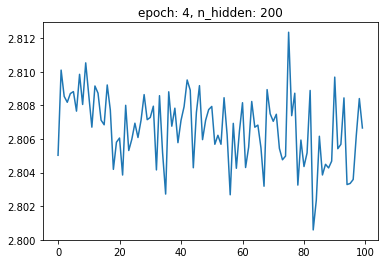

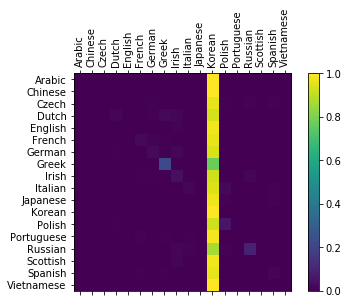

5000 5% (189m 29s) 2.8149 Ha / Scottish ✗ (Vietnamese)
10000 10% (191m 18s) 2.7673 Shi / Chinese ✓
15000 15% (193m 6s) 2.8216 Ko / Chinese ✗ (Korean)
20000 20% (194m 55s) 2.8742 Niu / Chinese ✓
25000 25% (196m 44s) 2.7805 Ko / Vietnamese ✗ (Korean)
30000 30% (198m 33s) 2.7957 Long / Arabic ✗ (Chinese)
35000 35% (200m 22s) 2.8404 Hor / Chinese ✓
40000 40% (202m 12s) 2.7889 Dinh / Chinese ✗ (Vietnamese)
45000 45% (204m 1s) 2.7911 Ma / Arabic ✗ (Vietnamese)
50000 50% (205m 50s) 2.7717 Vo / Vietnamese ✓
55000 55% (207m 40s) 2.7992 Dam / Vietnamese ✓
60000 60% (209m 29s) 2.8185 Ku / Vietnamese ✗ (Korean)
65000 65% (211m 18s) 2.8484 Wan / Korean ✗ (Chinese)
70000 70% (213m 7s) 2.7866 Fei / Arabic ✗ (Chinese)
75000 75% (214m 56s) 2.8165 Tron / Korean ✗ (Vietnamese)
80000 80% (216m 45s) 2.8696 La / Chinese ✗ (Vietnamese)
85000 85% (218m 35s) 2.8124 Bui / Chinese ✓
90000 90% (220m 24s) 2.8105 Phi / Chinese ✗ (Vietnamese)
95000 95% (222m 13s) 2.7090 an / Vietnamese ✓
100000 100% (224m 3s) 2.6984

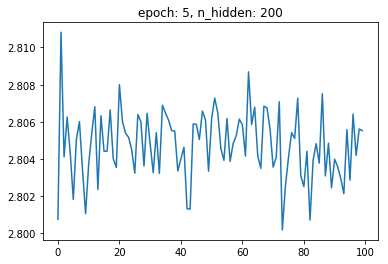

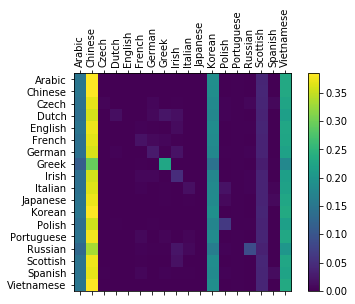

test accuracy:  0.0860433354973793
test error:  0.9139566645026207
test class wise accuracy:
Arabic 0.0
Chinese 0.0
Czech 0.005959756672382355
Dutch 0.015198118053376675
English 0.0
French 0.019214851781725883
German 0.026431718841195107
Greek 0.23463721573352814
Irish 0.04284936189651489
Italian 0.015046226792037487
Japanese 0.0
Korean 1.0
Polish 0.06269554793834686
Portuguese 0.0
Russian 0.09264272451400757
Scottish 0.008106160908937454
Spanish 0.012400142848491669
Vietnamese 0.0


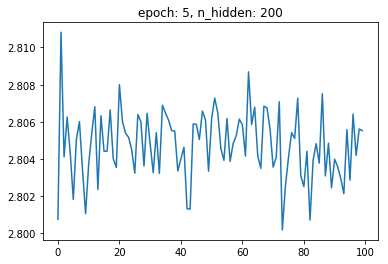

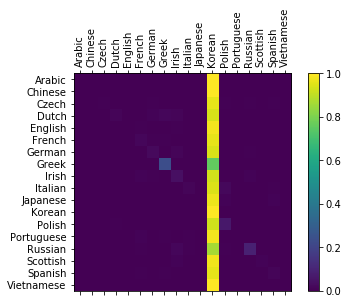

5000 5% (227m 18s) 2.7502 Vo / Korean ✗ (Vietnamese)
10000 10% (229m 6s) 2.7875 Si / Korean ✓
15000 15% (230m 54s) 2.7879 Seo / Chinese ✗ (Korean)
20000 20% (232m 42s) 2.8493 Ho / Chinese ✗ (Vietnamese)
25000 25% (234m 30s) 2.7867 Ba / Chinese ✗ (Arabic)
30000 30% (236m 19s) 2.8213 Xue / Arabic ✗ (Chinese)
35000 35% (238m 8s) 2.8030 La / Korean ✗ (Vietnamese)
40000 40% (239m 57s) 2.8594 Le / Vietnamese ✓
45000 45% (241m 46s) 2.7424 Ri / Korean ✓
50000 50% (243m 36s) 2.8202 Thi / Chinese ✗ (Vietnamese)
55000 55% (245m 25s) 2.7955 Yao / Chinese ✓
60000 60% (247m 14s) 2.6616 Rao / Arabic ✗ (Italian)
65000 65% (249m 3s) 2.8701 Gu / Arabic ✗ (Korean)
70000 70% (250m 53s) 2.7465 Luc / Vietnamese ✓
75000 75% (252m 42s) 2.7800 So / Chinese ✗ (Korean)
80000 80% (254m 31s) 2.8330 Ha / Vietnamese ✓
85000 85% (256m 21s) 2.8031 Aue / Korean ✗ (German)
90000 90% (258m 10s) 2.8628 Ly / Arabic ✗ (Vietnamese)
95000 95% (260m 2s) 2.9284 Nie / Chinese ✓
100000 100% (261m 52s) 2.8069 Yu / Chinese ✗ (Korea

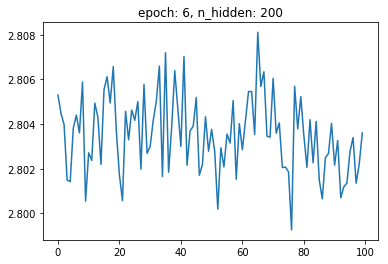

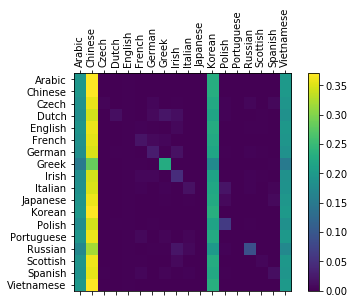

test accuracy:  0.08516667038202286
test error:  0.9148333296179771
test class wise accuracy:
Arabic 0.0
Chinese 1.0
Czech 0.005114320199936628
Dutch 0.013247000053524971
English 0.0
French 0.02051437273621559
German 0.02407362312078476
Greek 0.223709836602211
Irish 0.04993228614330292
Italian 0.018835309892892838
Japanese 0.0011455444619059563
Korean 0.0
Polish 0.06716153770685196
Portuguese 0.0
Russian 0.08674176037311554
Scottish 0.010054844431579113
Spanish 0.010658797807991505
Vietnamese 0.0


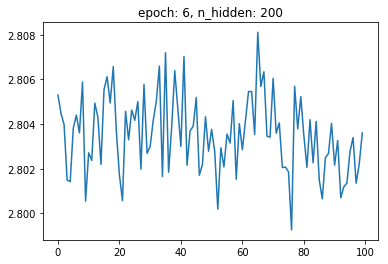

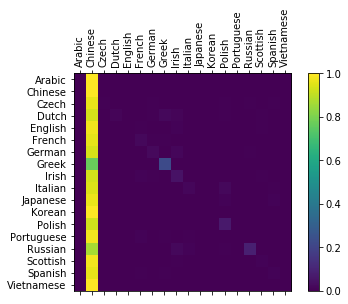

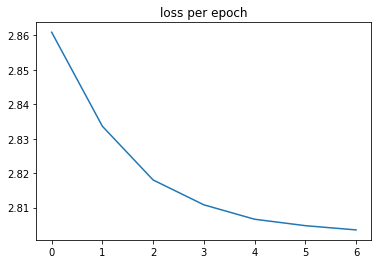

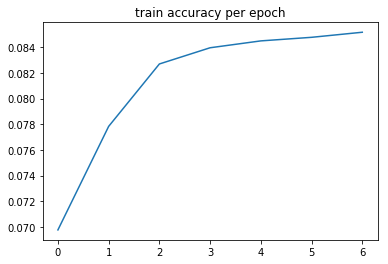

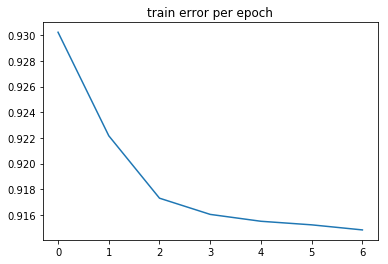

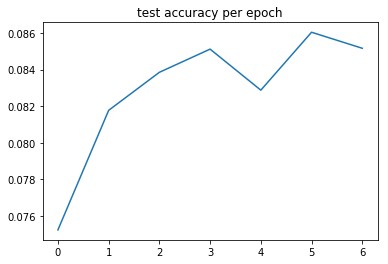

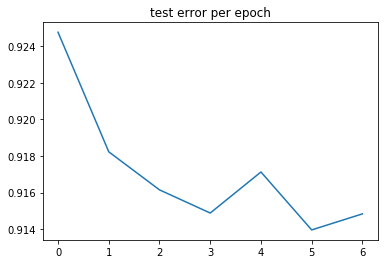

In [23]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
n_hidden1 = 128
n_hidden2 = 200
n_hidden3 = 300
batch_size = 1
num_layers = 1

n_iters = 100000
print_every = 5000
plot_every = 1000
n_confusion = 10000
criterion = nn.NLLLoss()

batch_size_ls = [1,2,10,30]
# batch_size = 2
epoch = 7
for batch_size in batch_size_ls:
    lstm1new = LSTMnew(n_letters,n_hidden1,batch_size,num_layers,n_categories)

    optimizer1new = optim.SGD(lstm1new.parameters(), lr=0.1)
    trainAndValidateBatch(n_iters,print_every,plot_every,epoch,n_confusion,lstm1new,optimizer1new,criterion,n_hidden2,learning_rate,batch_size)